#HandleidingVisualisatie5GuidoGezelleGeo


Dit is een voorbeeld van een netwerkvisualisatie omtrent Guido Gezelle met beschikbare data op Wikidata. Deze visualisatie vormt de eerste vierde van meerdere visualisaties omtrent Guido Gezelle op Wikidata. In deze visualisatie wordt dieper ingegaan op de chronologie van de correspondentienetwerken. Deze aanpak richt zich op verandering over tijd en de evolutie van Gezelles sociale kring. Er worden relaties tussen mensen, plaatsen en beroepen in het netwerk van Guido Gezelle getoond. Wat volgt, is een handleiding om deze visualisatie te creeëren.

##VRAAG

Vraag: Hoe evolueerde het sociale netwerk van Gezelle over de tijd? Welke gemeenschappen (clusters) waren belangrijk in verschillende levensfases of periodes (bijv. de periode van zijn priesterschap in Roeselare vs. de periode in Brugge)? Welke relevante personen van Guido Gezelle of waarvan Guido Gezelle zelf relevant persoon was, waren ook relevant persoon met elkaar over de tijd heen? Wat was het moment, de start en/of eindtijd van deze relaties? Daarbij willen we kijken we ook de werklocatie (work location), woonplaats (residents), beroep (occupation) en werkgever (employer) met bijhorende tijdstippen.

##QUERIES

Om deze vragen te beantwoorden, zullen we gebruik maken van de informatie die beschikbaar is op Wikidata omtrent Guido Gezelle. Op Wikidata is veel informatie verzameld en volgens een specifiek relationeel model gestructureerd. Zo kan data eenvoudig aan elkaar gelinkt worden en in relatie tot elkaar opgevraagd worden. Hiervoor gebruiken we de Wikidata Query service. In deze service is het mogelijk om queries te ontwerpen op basis van codetaal. De codetaal die hiervoor gebruikt wordt is SPARQL. Over deze codetaal is veel documentatie terug te vinden. Hieronder hebben we enkele queries opgesteld met behulp van deze service. Daarnaast hebben we ook gebruik gemaakt van generatieve AI, in dit geval Gemini om de queries te stroomlijnen of wat tijd uit te sparen bij het testen van enkele varianten.

Opmerking: de rekencapaciteit van Wikidata Query Service is snel overbelast. Queries mogen dus niet te uitgebreid of complex zijn. Dit zorgt voor server overload. Om die reden worden in deze voorbeelden de vraagstelling opgedeeld in verschillende deelvragen, die elk met een simpele query beantwoord kunnen worden.

Om deze visualisatie tot stand te brengen, moeten er in dit geval twee queries samengesteld worden. De eerste query kijkt naar alle significante personen in het netwerk van Guido Gezelle, of waarvan Guido Gezelle significant persoon is. Daarbij geeft heft de richting van die relatie, alsook welke rol die significante persoon heeft (bv correspondent), alsook geeft het start, eind en puntdatum van deze relatie (vooral resultaten bij correspondenten). Zowel de relaties met Guido Gezelle worden opgeroepen, alsook de significante relaties van deze personen onderling.

###Query1

In [ ]:
SELECT DISTINCT
  ?source ?sourceLabel    # De Subject / Zender
  ?target ?targetLabel    # De Object / Ontvanger
  ?richtingBeschrijving   # Duidelijke uitleg van de flow
  ?rolLabel               # De rol van de correspondent (op de statement)
  ?start ?eind ?punt      # De datums van de correspondentie
WHERE {
  VALUES ?gezelle { wd:Q336977 } # Guido Gezelle ID

  # ------------------------------------------------------------------
  # A. Guido Gezelle ↔ relevante persoon Relaties
  # ------------------------------------------------------------------
  {
    # Case 1a: Guido is Source (Zender)
    ?gezelle p:P3342 ?stmt.
    ?stmt ps:P3342 ?target.
    BIND(?gezelle AS ?source)
    FILTER(?target != ?gezelle)
    # NEW: Richting label
    BIND("Guido (Zender) → Relevant Persoon (Ontvanger)" AS ?richtingBeschrijving)
  }
  UNION
  {
    # Case 1b: Guido is Target (Ontvanger)
    ?source p:P3342 ?stmt.
    ?stmt ps:P3342 ?gezelle.
    BIND(?gezelle AS ?target)
    FILTER(?source != ?gezelle)
    # NEW: Richting label
    BIND("Relevant Persoon (Zender) → Guido (Ontvanger)" AS ?richtingBeschrijving)
  }

  # ------------------------------------------------------------------
  # B. relevante persoon ↔ relevante persoon Relaties (Onderling)
  # ------------------------------------------------------------------
  UNION
  {
    # Zorg dat de Source een Gezelle relevant persoon is (Performance filter)
    { ?gezelle p:P3342/ps:P3342 ?source. } UNION { ?source p:P3342/ps:P3342 ?gezelle. }

    # Zorg dat de Target een Gezelle relevant persoon is (Performance filter)
    { ?gezelle p:P3342/ps:P3342 ?target. } UNION { ?target p:P3342/ps:P3342 ?gezelle. }

    # Zoek de P3342 relatie direct tussen hen
    ?source p:P3342 ?stmt.
    ?stmt ps:P3342 ?target.

    # Filters
    FILTER(?source != ?gezelle)
    FILTER(?target != ?gezelle)
    FILTER(?source != ?target)
    # NEW: Richting label
    BIND("Onderlinge Correspondentie (Source → Target)" AS ?richtingBeschrijving)
  }

  # ------------------------------------------------------------------
  # C. Qualifiers en Labels (Gedeeld door alle UNION blocks)
  # ------------------------------------------------------------------

  # Rol (P3831) - Dit is de rol van de Source in de relevante persoonsrelatie
  OPTIONAL {
    ?stmt pq:P3831 ?rol.
    ?rol rdfs:label ?rolLabel filter (lang(?rolLabel) = "nl").
  }

  # Timestamps
  OPTIONAL { ?stmt pq:P580 ?start. }
  OPTIONAL { ?stmt pq:P582 ?eind. }
  OPTIONAL { ?stmt pq:P585 ?punt. }

  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?source rdfs:label ?sourceLabel.
    ?target rdfs:label ?targetLabel.
  }
}
ORDER BY ?sourceLabel
LIMIT 5000

In de tweede query worden van deze groep (significante personen) ook alle timestamps omtrent work location, residents, occupation en employer opgevraagd. We vragen alle personen op die een significante relatie hebben met Guido, of omgekeerd, en vervolgens vragen we start, eind en punttijd van woonplaats, werkgever, beroep en werklocatie.

###Query2

In [ ]:
SELECT DISTINCT
  ?person ?personLabel
  ?relatieLabel         # De naam van de property (Woonplaats, Beroep, etc.)
  ?value ?valueLabel    # Het object (de Stad, Organisatie of het Concept)
  ?start ?eind ?punt    # De timestamps (P580, P582, P585)
WHERE {
  VALUES ?gezelle { wd:Q336977 }

  # 1. Definieer de Groep: Alle relevante personen van Gezelle
  { ?gezelle p:P3342/ps:P3342 ?person. } UNION { ?person p:P3342/ps:P3342 ?gezelle. }

  # 2. Zoek de 4 specifieke relaties expliciet via UNION
  {
    # Woonplaats (P551)
    ?person p:P551 ?stmt.
    ?stmt ps:P551 ?value.
    BIND("Woonplaats" AS ?relatieLabel)
  }
  UNION
  {
    # Werkgever (P108)
    ?person p:P108 ?stmt.
    ?stmt ps:P108 ?value.
    BIND("Werkgever" AS ?relatieLabel)
  }
  UNION
  {
    # Werklocatie (P937)
    ?person p:P937 ?stmt.
    ?stmt ps:P937 ?value.
    BIND("Werklocatie" AS ?relatieLabel)
  }
  UNION
  {
    # Beroep (P106)
    ?person p:P106 ?stmt.
    ?stmt ps:P106 ?value.
    BIND("Beroep" AS ?relatieLabel)
  }

  # 3. Haal de timestamps op uit de statement node (?stmt)
  OPTIONAL { ?stmt pq:P580 ?start. }
  OPTIONAL { ?stmt pq:P582 ?eind. }
  OPTIONAL { ?stmt pq:P585 ?punt. }

  # 4. Labels ophalen
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl,en".
    ?person rdfs:label ?personLabel.
    ?value rdfs:label ?valueLabel.
  }
}
ORDER BY ?person ?relatieLabel
LIMIT 10000

De volgende vier queries zijn een opdeling van query twee. Soms hadden we wat problemen met Wikidata Query Service, waardoor we voor de zekerheid vier queries hebben opgesteld, die dezelfde informatie weergeven in lichter formaat.

Onderstaande query toont bijkomend de starttijd, eindttijd en/of punttijd omtrent woonplaatsen van relevante personen in het netwerk van Guido Gezelle.

###Query3

In [ ]:
SELECT DISTINCT
  ?person ?personLabel
  ?contextNode ?contextNodeLabel # Dit is de woonplaats
  "Woonplaats" AS ?type
  (YEAR(?start) AS ?startJaar)
  (YEAR(?eind) AS ?eindJaar)
  (YEAR(?punt) AS ?puntJaar)
WHERE {
  VALUES ?gezelle { wd:Q336977 }
  { ?gezelle wdt:P3342 ?person. } UNION { ?person wdt:P3342 ?gezelle. }

  OPTIONAL {
    ?person p:P551 ?stmt.
    ?stmt ps:P551 ?contextNode.
    OPTIONAL { ?stmt pq:P580 ?start. }
    OPTIONAL { ?stmt pq:P582 ?eind. }
    OPTIONAL { ?stmt pq:P585 ?punt. }
  }

  FILTER(BOUND(?contextNode)) # Filter de rijen zonder woonplaats data.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "nl". }
}

Onderstaande query toont bijkomend de starttijd, eindttijd en/of punttijd omtrent werklocaties van relevante personen in het netwerk van Guido Gezelle.

###Query4

In [ ]:
SELECT DISTINCT
  ?person ?personLabel
  ?contextNode ?contextNodeLabel # Dit is de werklocatie
  "Werklocatie" AS ?type
  (YEAR(?start) AS ?startJaar)
  (YEAR(?eind) AS ?eindJaar)
  (YEAR(?punt) AS ?puntJaar)
WHERE {
  VALUES ?gezelle { wd:Q336977 }
  { ?gezelle wdt:P3342 ?person. } UNION { ?person wdt:P3342 ?gezelle. }

  OPTIONAL {
    ?person p:P937 ?stmt.
    ?stmt ps:P937 ?contextNode.
    OPTIONAL { ?stmt pq:P580 ?start. }
    OPTIONAL { ?stmt pq:P582 ?eind. }
    OPTIONAL { ?stmt pq:P585 ?punt. }
  }

  FILTER(BOUND(?contextNode))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "nl". }
}

Onderstaande query toont bijkomend de starttijd, eindttijd en/of punttijd omtrent werkgever van relevante personen in het netwerk van Guido Gezelle.

###Query5

In [ ]:
SELECT DISTINCT
  ?person ?personLabel
  ?contextNode ?contextNodeLabel # Dit is de werkgever
  "Werkgever" AS ?type
  (YEAR(?start) AS ?startJaar)
  (YEAR(?eind) AS ?eindJaar)
  (YEAR(?punt) AS ?puntJaar)
WHERE {
  VALUES ?gezelle { wd:Q336977 }
  { ?gezelle wdt:P3342 ?person. } UNION { ?person wdt:P3342 ?gezelle. }

  OPTIONAL {
    ?person p:P108 ?stmt.
    ?stmt ps:P108 ?contextNode.
    OPTIONAL { ?stmt pq:P580 ?start. }
    OPTIONAL { ?stmt pq:P582 ?eind. }
    OPTIONAL { ?stmt pq:P585 ?punt. }
  }

  FILTER(BOUND(?contextNode))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "nl". }
}

Onderstaande query toont bijkomend de starttijd, eindttijd en/of punttijd omtrent beroep van relevante personen in het netwerk van Guido Gezelle.

###Query6

In [ ]:
SELECT DISTINCT
  ?person ?personLabel
  ?contextNode ?contextNodeLabel # Dit is het Beroep (P106) item
  ()"Beroep" AS ?type)
  (YEAR(?start) AS ?startJaar)
  (YEAR(?eind) AS ?eindJaar)
  (YEAR(?punt) AS ?puntJaar)
WHERE {
  VALUES ?gezelle { wd:Q336977 }

  # 1. Groep Selectie: Alle P3342-gerelateerde personen
  { ?gezelle wdt:P3342 ?person. } UNION { ?person wdt:P3342 ?gezelle. }

  # 2. De Simpele Zoekopdracht voor P106 statements
  ?person p:P106 ?stmt.
  ?stmt ps:P106 ?contextNode. # De contextNode is hier het Beroep (bijv. dichter)

  # Tijd-qualifiers (Optioneel)
  OPTIONAL { ?stmt pq:P580 ?start. }
  OPTIONAL { ?stmt pq:P582 ?eind. }
  OPTIONAL { ?stmt pq:P585 ?punt. }

  FILTER(?person != ?gezelle)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "nl". }
}
ORDER BY ?person ?startJaar

Opmerking: bijkomend kan bijvoorbeeld nog een afbeelding en wikipedia pagina gevraagd worden. Hier gaan we momenteel niet verder op in. Hiervoor kan verwezen worden naar de handleidingen van de andere visualisaties.

##EXPORT

Vervolgens moet de data gedownload worden en verder worden verwerkt in software zoals Spreadsheets, Excel en/of OpenRefine. Hier is het doel om een bestand met knopen en een bestand met verbindingen te maken, aangezien dat de twee bouwstenen van de visualisatie worden.In dit geval werden de queries zodanig ontworpen dat er erg weinig werk is in het samenstellen van deze documenten. In de andere visualisaties omtrent Guido Gezelle wordt hier dieper op ingegaan, omdat het daar wel nodig is meer bewerkingen te doen met de resultaten van de queries.

Eerst en vooral exporteren we alle resultaten van de queries als afzonderlijke bestanden en geven ze een duidelijke naam 'RawV5Q1', 'RawV5Q2 , enzovoort. In google spreadsheets worden de gegevens verder bewerkt. Hieronder worden daarvoor alle stappen doorlopen. Open Spreadsheets of Excel en importeer één voor één de verschillende gedownloade bestanden met de resultaten van de queries, elk afzonderlijk als nieuw tabblad in hetzelfde spreadsheet-project. Noem de tabbladen 'RawV5Q1', 'RawV5Q2', enzovoort. We zullen hier later kopieën van maken om op veilige wijze bewerkingen te doen in verband met de tijdstippen. Dat verklaart tevens het grote aantal tabbladen in onderstaande afbeelding.

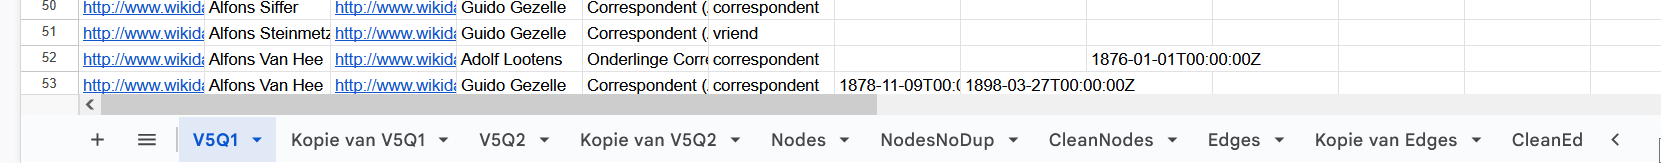

##NODES

Vervolgens zullen we de data uit deze twee queries moeten combineren om tot de uiteindelijke knopenbestand en verbindingenbestand te komen. Geen van de queries geeft direct een definitieve nodes-lijst. je moet deze zelf samenstellen door alle unieke ID's uit de resultaten van beide queries te aggregeren. In dit geval zijn dit alle personen, alle plaatsen en alle beroepen.

1. Om alle personen te verzamelen, kunnen we eerst en vooral Source en Sourcelabel kopieëren in een nieuw tabblad en dat de naam 'nodes' geven. Geef de kolommen de naam 'ID' en 'Label'. Daaronder kan vervolgens de inhoud van kolommen  'target' en 'targetlabel' gekopieërd en geplakt worden. Vervolgens worden ook de inhoud van kolommen 'person' en 'personlabel' van de tweede query gekopieerd en geplakt onder de vorige namen. Maak een derde kolom 'category' aan en vul de waarde 'persoon' in een cel. Sleep deze waarde naar beneden zodat alle personen tot de categorie 'persoon' behoren.

2. Vervolgens kunnen we ook alle beroepen en plaatsen verzamelen in het node bestand. Hiervoor kopieëren we de kolommen 'value' en valuelabel' uit de tweede query en plakken deze onder de personen in het nodes-bestand. Om de kolom 'category' in te vullen, kunnen we de kolom 'relatielabel' uit de tweede query kopieëren en plakken in de kolom type bij de respectievelijke items. Op die manier hebben alle knopen een type.

3. Toevoegen van de jaartallen: hiervoor maken we eerst een kopie van het tabblad van query 1. Hier zullen we enkele kolommen aanmaken om verschillende bewerking op de data door te voeren, zodat we met de jaartallen overblijven. Omdat er niet enkel een start- en eindtijd wordt gegeven, maar soms ook een punttijd (momentopname), moeten er wat formules opgesteld worden om deze data te bewerken. Uiteindelijk willen we overblijven met een startjaar en eindjaar in plaats van een volledige DD-MM-YYYY-structuur.

Om dit te doen kunnen we eerst de jaartallen extraheren uit de data.
maak een nieuwe kolom voor start , eind en puntdatum (noem ze bv 'Startyear', 'endyear', enzovoort) en gebruik volgende formule:


```
=IFERROR(LEFT(G2; 4); "")
```

De formule probeert de eerste vier tekens uit cel G2 (in dit geval kolom 'start') te halen. Als deze bewerking slaagt, toont de formule die vier tekens. Als de bewerking faalt (bijvoorbeeld omdat cel G6 leeg is, wat in sommige versies een fout kan veroorzaken), dan zorgt de IFERROR-functie ervoor dat de cel leeg blijft in plaats van een foutmelding zoals #WAARDE! of #FOUT! te tonen. Tot slot kopieer je deze waarden en plakt ze in dezelfde kolom. Kies daarbij om enkel 'waarden' te plakken in het optie-venster. Op die manier wordt '1886-06-01T00:00:00Z' omgezet in '1886'. Herhaal dit voor eind en punttijd.

Tot slot maken we twee nieuwe kolommen 'StartyearFinal' en 'EndyearFinal'. Hier zullen we een formule opstellen die eerst de waarde neemt van start en indien die leeg is, kijkt naar de puntwaarde. Hetzelfde voor de eindtijd.


```
=IF(I3=""; O3; I3)
```

De betekenis hiervan is: als cel met starttijd leeg is, neem dan de punttijd. Is de waarde van starttijd niet leeg, neem dan die waarde. Hetzelfde kan gelezen worden voor de eindtijd. Op die manier blijven we met twee tijdstippen over. Deze kunnen we voor alle personen kopieren naar het nodes-bestand in twee nieuwe kolommen, genaamd 'startjaar' en 'eindjaar'.

4. extra attributen. Om de visualisatie interessanter te maken willen we graag nog een extra informatie toevoegen aan de knopen. In het geval van de personen kunnen we bijvoorbeeld de rol die ze hadden ten aanzien van Guido expliciteren. Daarnaast kunnen we ook een foto proberen te voorzien voor al deze knopen. Om de rol toe te voegen kunnen we volgende formule opstellen.

`= VLOOKUP(B2;V5Q1!B:F;5;0)`

leest als: we kijken naar de naam in cel B2 en zoeken deze op in de eerste query in kolom B, vervolgens geven we als resultaat de 5de kolom geteld vanaf kolom B. De waarde '0' geeft aan dat het om een exacte match moet gaan.

Bij sommige personen kregen we geen resultaten: we zijn dan even gaan kijken in de target-groep in plaats van de source-groep met onderstaande formule:

`= VLOOKUP(B2;V5Q1!B:F;5;0)`

Om de afbeeldingen nog te verzamelen, kan je een variant van query 1 en query 2 waarbij je enkel de links naar de foto's vraagt. We kunnen deze dan linken via de VLOOKUP-functie. Echter leek het niet zo nuttig dit te doen, behalve voor de personen.

5. Wikidata URL's verwijderen in de Id-kolom: Gephi kan enkel werken met de Q-nummers, niet met links. Dit kan eenvoudig opgelost worden door de kolom met de links te selecteren en dan in het hoofdmenu (bovenaan) te kiezen voor 'bewerken' en vervolgens 'zoeken en vervangen' te kiezen. Daar kan je instellen om 'http://www.wikidata.org/entity/' te vervangen door '' (leegte). Hierna blijf je enkel met de Q-nummers over. Daarna kopieer je de kolom en plak je ze terug op dezelfde plaats, maar kies 'enkel waarden plakken' in het submenu.

6. duplicaten verwijderen: knopen mogen maar een keer voorkomen in de visualisatie. Daarom is het belangrijk alle dubbels te verwijderen. Dat kan door in het hoofdmenu naar in het hoofdmenu te klikken op 'gegevens' - 'gegevens opschonen' - 'duplicaten verwijderen'. Let erop dat je alle kolommen selecteert.

7. Vervolgens kun je de tab de naam 'nodes' geven, indien dit nog niet is gebeurd. Via exporteren of downloaden kun je kiezen om het csv-bestand te downloaden.

opmerking: in retrospect zijn we vergeten de afbeeldingen van de plaatsen en landen, alsook hun wikidata links, wikipedia, enzovoort op te vragen. Dit kan nog aangevuld worden, maar hier gaan we momenteel niet dieper op in.


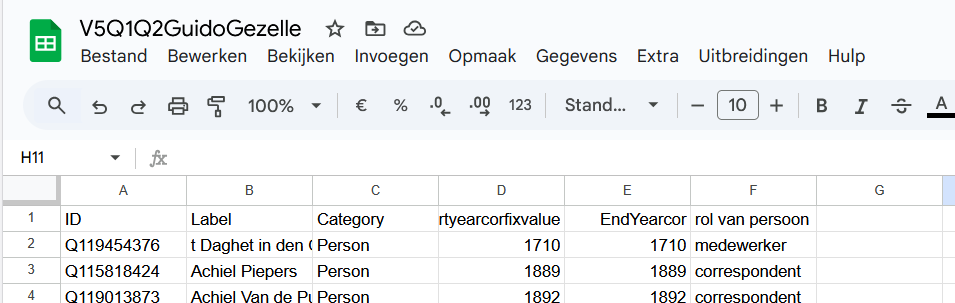

##EDGES

Nu het knopenbestand klaar is, kunnen we beginnen met het verbindingenbestand.
We hebben twee soorten verbindingen: 1) Sociale Edges: Persoon ↔ Persoon.	De basis van het netwerk: wie correspondeerde met wie, en wanneer (?start, ?eind, ?punt), en 2) contextuele Edges:	Persoon → Plaats/Concept. Dit zijn de attributen: waar woonde/werkte iemand, welke werkgever of beroep en in welke periode.

1. Eerst zullen we de sociale verbindingen samenstellen. Kopieer de kolommen 'source','target','role','Startyearfinal' en 'Endyearfinal' van query 1 en plak ze in een nieuw tabblad met de naam 'edges'.Kies voor de namen van de kolommen voor Source, Target, Role, startyear, endyear.

2. Kopieer daarna de kolommen  'Person', 'Value', 'RelatieLabel', Startyear, Endyear. Dit zijn uw geografische/professionele randen. Plak deze onder de sociale edges in . De kolommen zouden overeen moeten komen met wat er reeds staat.

3. Na de sourcekolom en targetkolom, kunnen we een derde en vierde kolom invoegen. Deze noemen we 'Type' en 'Weight'. We vullen bij type de waarde 'directed' in (of undirected; maakt op zich niet zoveel uit). We slepen de waarde voor alle relaties naar beneden. Voor 'weight' vullen we de waarde '1' in. Dit doen we op dezelfde manier voor alle relaties door de waarde van de eerste cel naar beneden te slepen.

4. Wikidata URL's verwijderen in de Id-kolom: Gephi kan enkel werken met de Q-nummers, niet met links. Dit kan eenvoudig opgelost worden door de kolom met de links te selecteren en dan in het hoofdmenu (bovenaan) te kiezen voor 'bewerken' en vervolgens 'zoeken en vervangen' te kiezen. Daar kan je instellen om 'http://www.wikidata.org/entity/' te vervangen door '' (leegte). Hierna blijf je enkel met de Q-nummers over. Daarna kopieer je de kolom en plak je ze terug op dezelfde plaats, maar kies 'enkel waarden plakken' in het submenu.

5. Vervolgens kun je de tab de naam 'edges' geven, indien dit nog niet is gebeurd. Via exporteren of downloaden kun je kiezen om het csv-bestand te downloaden.

Opmerking: in retrospect zijn we vergeten om de afbeeldingen van de plaatsen en landen, alsook hun wikidata links, wikipedia, enzovoort op te vragen. Dit had nog leuk geweest om verder mee te werken. Dit kan nog toegevoegd worden, maar hier gaan we momenteel niet verder op in.


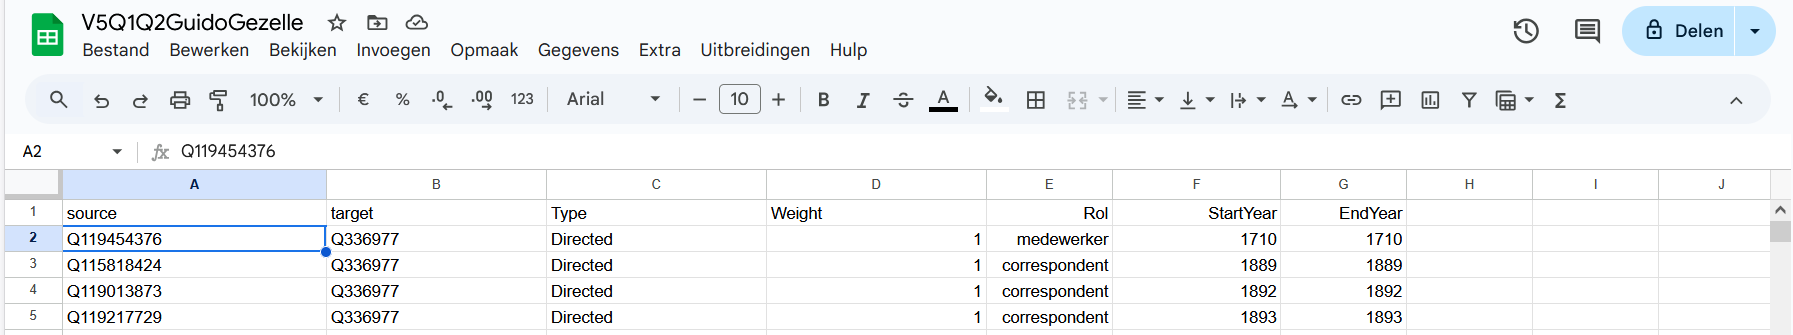

##GEPHI

In Gephi kunnen beide documenten (nodes en edges) opgeladen worden om een netwerkvisualisatie te bekomen. Hieronder wordt toegelicht hoe dat te doen.

Eerst laden we de nodes.csv in. Vervolgens laden we de edges.csv in hetzelfde spreadsheet in Gephi. Open Gephi en start een nieuw project. Vervolgens laden we eerst de node file in. Via 'file' en dan 'import spreadsheet' kunnen de documenten worden ingeladen. Selecteer het bestand en kies bij het menu 'import as' voor 'node table'. Klik een paar keer op 'next' en kies ervoor om de data op het huidige tabblad in te laden. Doe hetzelfde voor de edges-file, maar kies dan voor 'edges table'.

opmerking: Soms krijg je bij het inladen fouten zoals dubbele nodes. In sommige gevallen konden we dit niet onmiddellijk verklaren en/of oplossen. Op zich kun je gewoon verder inladen en dit oplossen in Gephi zelf. Moesten er toch foutjes zijn in de visualisatie (bijvoorbeeld met grote pijlen/edges), dan kan je in ' data laboratory' naar de 'edge'-tab kijken naar het gewicht van de edges. Je kunt in dit geval alles selecteren door te slepen en met een rechterklik kiezen voor 'edit edges'. Links zul je een menu zien waar je de weight variabele kunt aanpassen. Hier kun je de waarde 1 ingeven voor alle edges. Op die manier zijn alle verbindingen even sterk en ziet de visualisatie er terug 'normaal' uit.

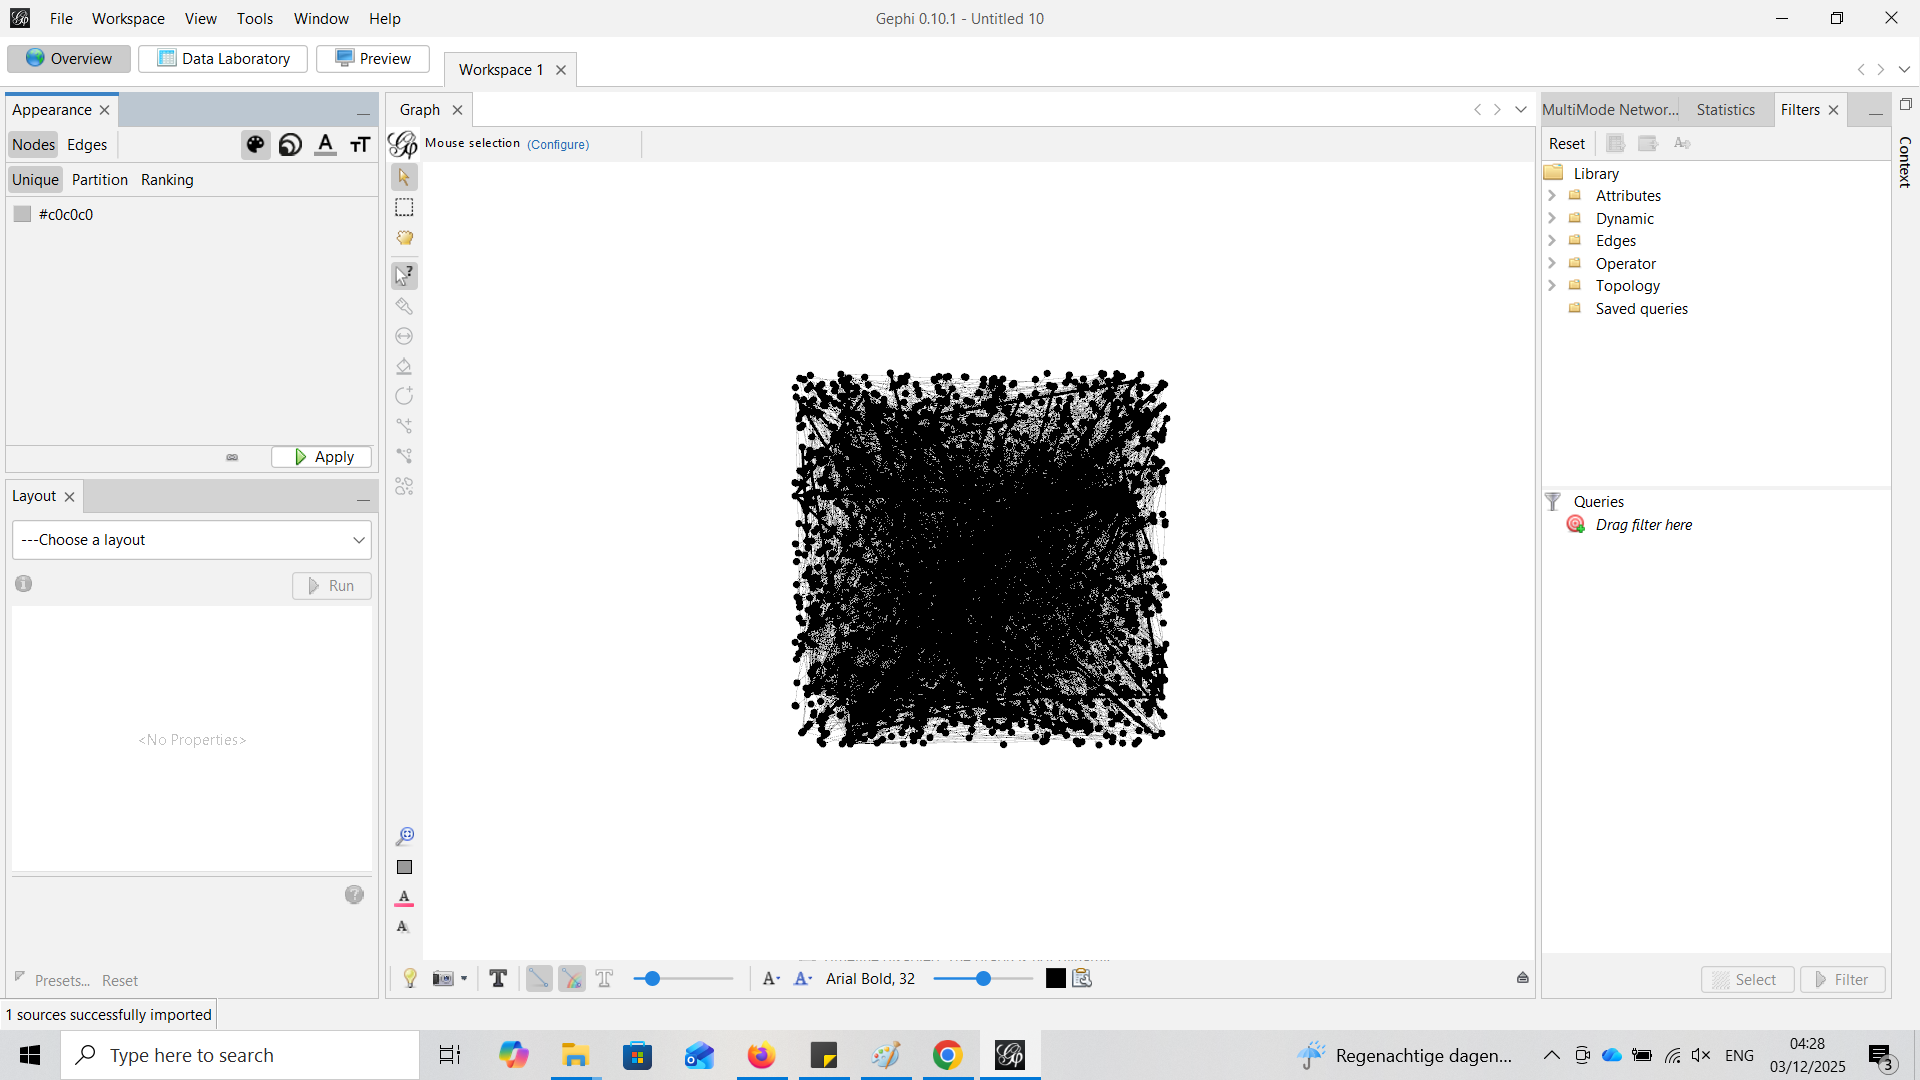


Nu beide bestanden zijn ingeladen, kan overgegaan worden op de layout van de graph. Ga in het hoofdmenu naar 'overview'. Je ziet nu volgende visualisatie:

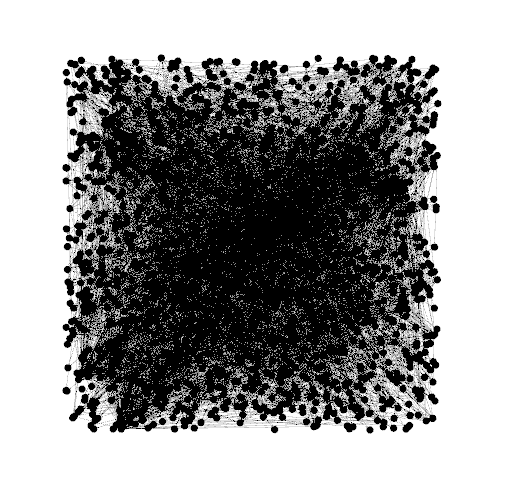


Nu beide bestanden zijn ingeladen, kan overgegaan worden op de layout van de graph. Ga in het hoofdmenu naar 'overview'. Je ziet nu volgende visualisatie:

Vervolgens ordenen we de visualisatie. Om tot de gewenste vorm te komen, kun je links bij 'layout' kiezen uit een lijst sorteeralgoritmes.  Hier kiezen we voor ForceAtlas2. Kies dit en pas de 'scaling' en 'gravity aan naar waarde '55' en druk op 'Run'. Na enkele minuten kun je ook ordenen op 'no overlap'. Je krijgt nu onderstaande vorm:

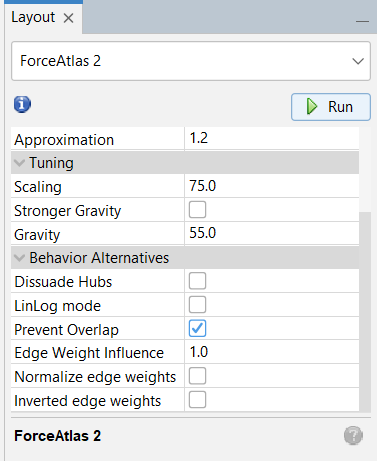

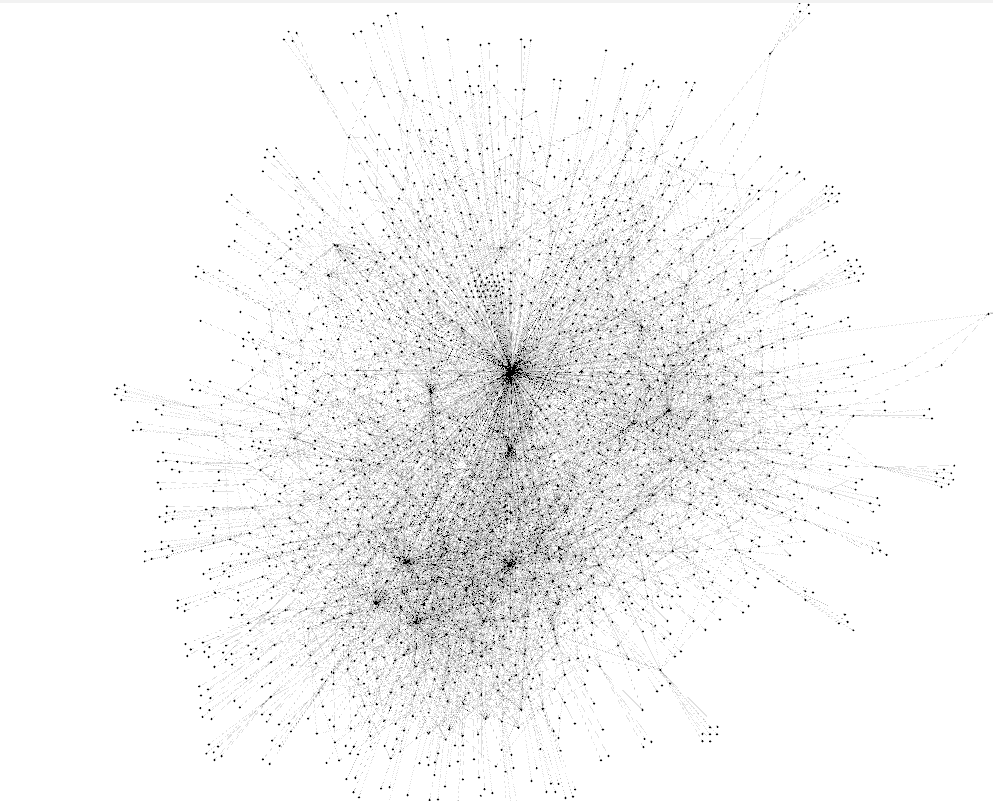

Vervolgens kunnen we ook de grootte en kleur van de knopen en verbindingen aanpassen om de visualisatie intuïtiever te maken.

De kleur van de knopen verwijst in dit geval naar het type (persoon of instelling). De grootte wordt bepaald door de 'degree';het aantal verbindingen met andere knopen. Beiden kunnen aangepast worden in het 'appearance'-menu aan de linkerkant. Indien dit niet zichtbaar is, kan het in het hoofdmenu (boven) geselecteerd worden onder het tabblad 'windows'.


je kan 'nodes' selecteren. Vervolgens klik je op de icoontjes naast 'node-edge'. Hier kun je de kleur aanpassen op basis van een attribuut, in dit geval 'category'. Om de grootte aan te passen klik je op het andere icoontje. Daarna kun je kiezen voor attribute 'Degree' en een min size van '10' en max size van '250' instellen. Mogelijk moet je daarna het sorteeralgoritme nogmaals laten draaien.

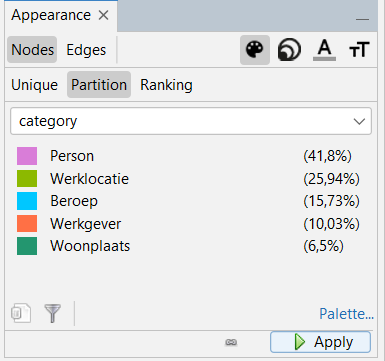

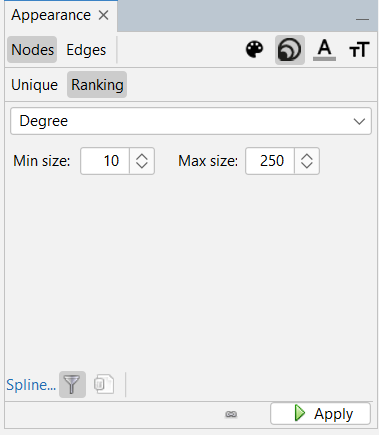

De kleur van de verbindingen wijst op het relatietype, in dit geval werkgever (paars), onderwijsinstelling (oranje) of lid van vereniging (groen). Ook dit kan geselecteerd worden in het 'appearance'-menu, in dit geval onder de 'edges' tab. Daar kies je voor attribuut 'relatiettype' en drukt op 'apply'. Ook de lijndikte van de edges kan aangepast worden. Daarvoor moet in dit geval geschoven met de waarde van het balkje naast het witte 'T' icoontje onder de visualisatie

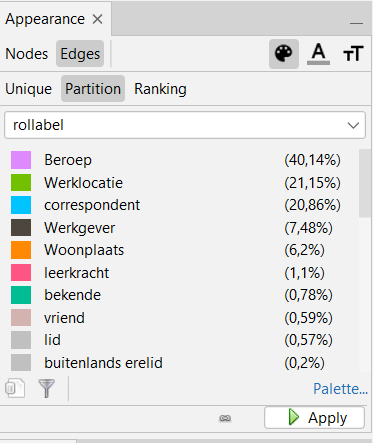

 Je kan de knoop van Guido Gezelle ook handmatig veranderen. Hier geven we deze een unieke kleur en bepalen we de grootte. Je kan daarvoor op het cursor-icoontje met een vraagteken klikken en vervolgens op de knoop van Guido Gezelle (de grootste). Er opent dan een paneel aan de linkerkant, waar je bepaalde waarden kunt aanpassen. Hier hebben we de grootte handmatig aangepast naar waarde '500' en de kleur van de knoop aangepast naar waarde '212,151,0'.

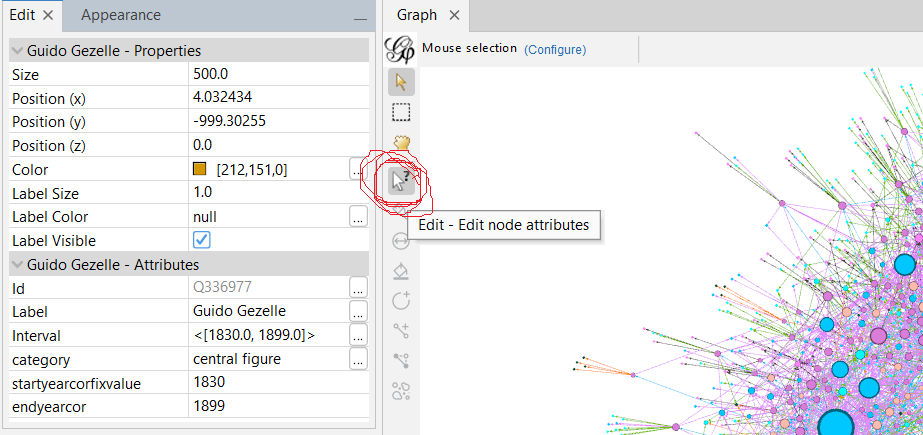

Na deze aanpassingen krijgen we volgende visualisatie te zien in het 'overview'-scherm

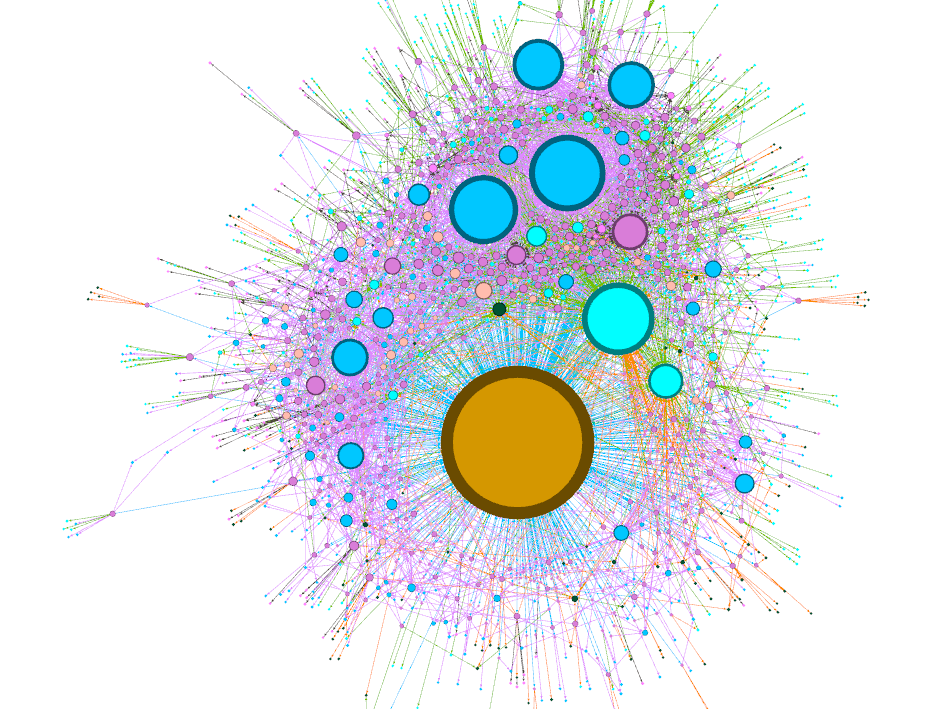

Het kan ook nog nog interessant zijn de verbindingen dikker te maken en de labels enkel zichtbaar te maken voor de geselecteerde knopen. De verbindingen kunnen dikker gemaakt worden in het preview scherm onder 'edges'- 'thickness'. Hier kan je de waarde verhogen. Een andere manier om de verbindingen en de pijlen dikker te maken is via het 'overview'-scherm. Hier kun je onder de visualisatie enkele tools vinden, bijvoorbeeld een grote witte letter 'T' (zie foto hieronder). Door de balk te verschuiven, worden de lijnen dikker.


Tot slot kan ook het label zichtbaar gemaakt worden wanneer deze geselecteerd wordt. Alle labels op elk moment tonen wordt te onoverzichtelijk. Om dit te doen, drukken we op het symbooltje rechts onderaan ten opzichte van de visualisatie. Er opent dan een extra menu waar onder het tabblad 'labels' gekozen kan worden voor 'highlight selection'. Vervolgens vinken we links het vakje naast 'Node' aan, om de nodes bij selectie zichtbaar te maken (zie foto).

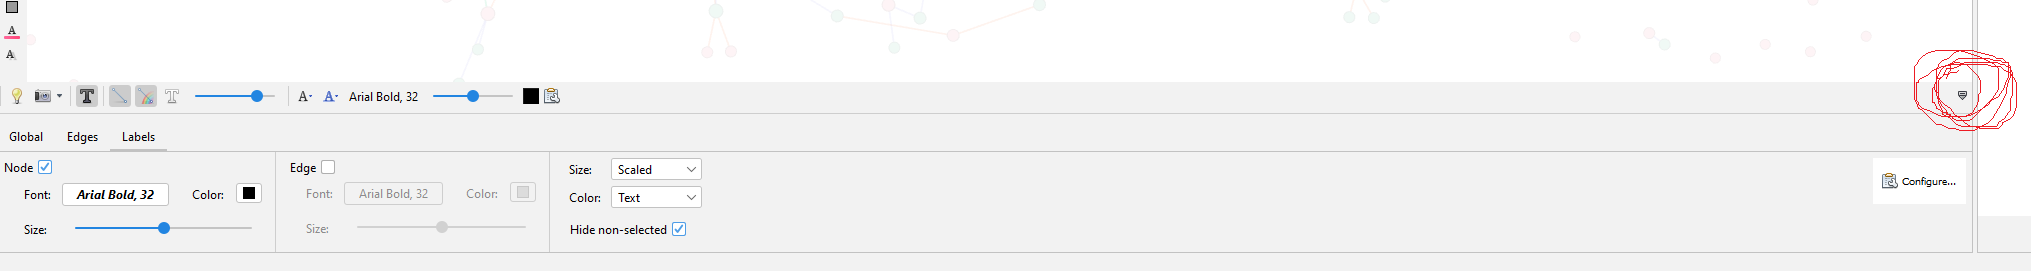

opmerkingen: in het 'preview'-blad van Gephi (naast Overview en Data laboratory) kunnen ook heel erg veel van deze en andere zaken aangepast worden in de visualisatie. Hier hebben we slechts enkele van de belangrijkste functies vanuit het 'overview'-menu voor deze visualisatie toegelicht.

**Tijdinterval maken**

Tot slot zullen we nog intervallen/periodes maken op basis van onze tijdsdata. Dit zullen we zowel voor de knopen als voor de verbindingen in orde maken.

Momenteel hebben we een startjaar en eindjaar. We kunnen deze twee kolommen samenvoegen in Gephi. Daarvoor gaan we naar 'Data laboratory' en klikken we op het nodes-tabblad. Onderaan deze tabel zijn enkele icoontjes terug te vinden om aanpassingen te maken aan kolommen. In dit geval kiezen we voor 'merge columns' (2de van links). Als we hierop klikken, krijgen we een venster waarin we de kolommen kunnen selecteren om samen te voegen. Klik op startyear en endyear. Pas vervolgens de Merge Strategy aan naar 'Create time interval'. Er zal een nieuwe kolom 'Interval' verschijnen, die alle periodes van de knopen bevat.

We kunnen hetzelfde herhalen voor het edges-tabblad om intervallen te creeëren.

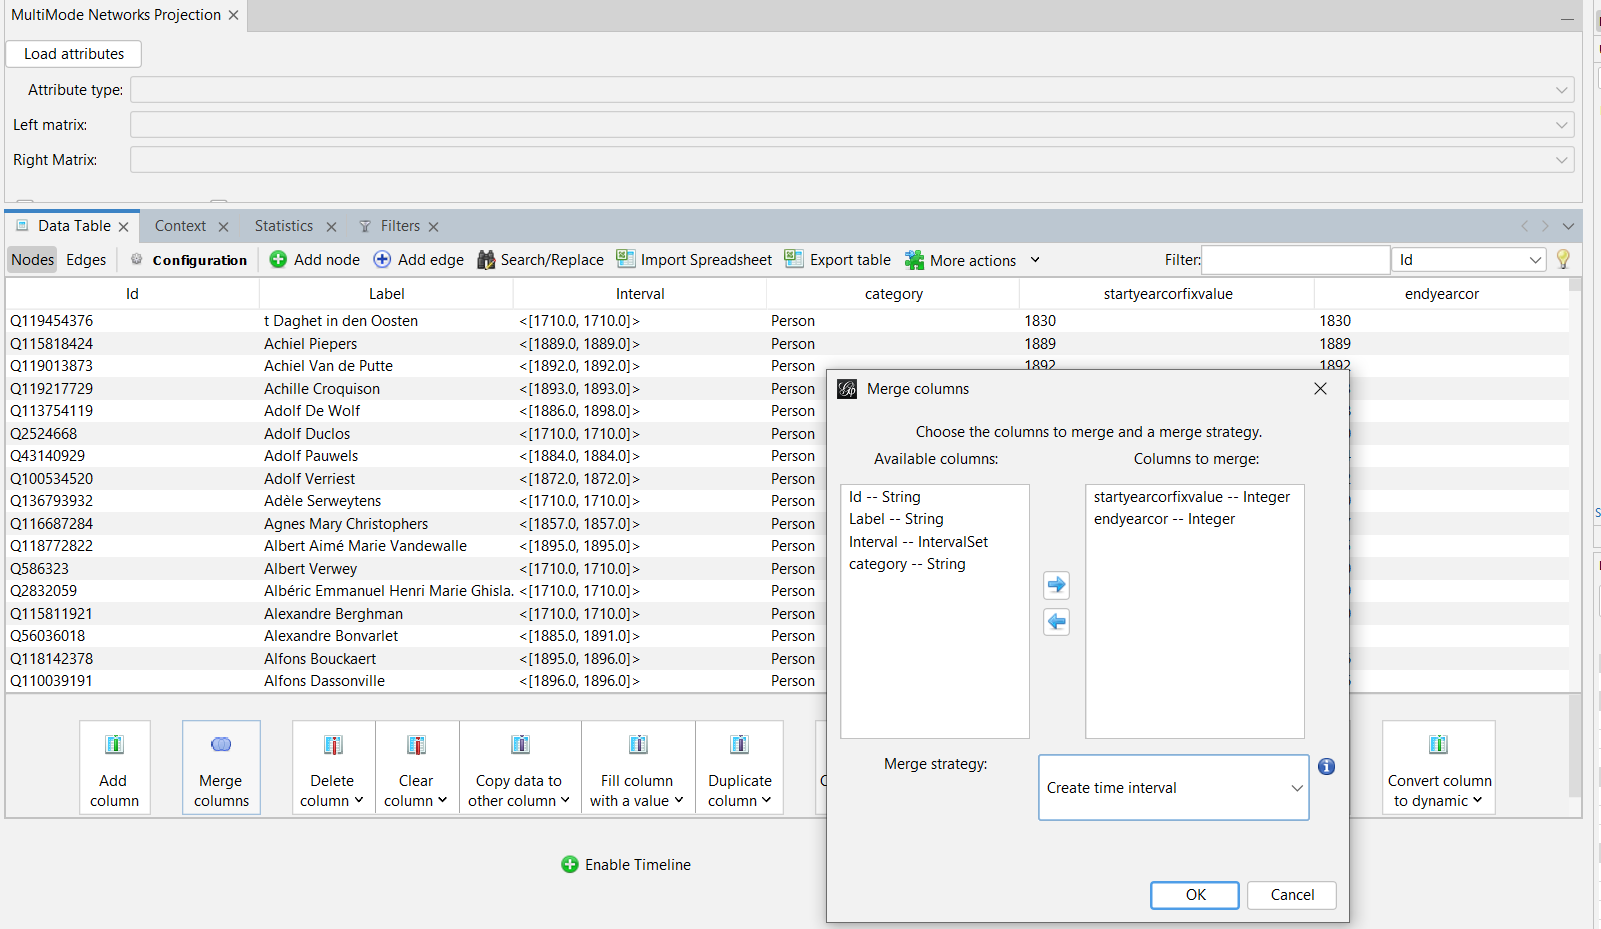

Je kan nu terugkeren naar het 'overview' tabblad om de visualisatie te bekijken. Er zal normaal niets veranderd zijn. Onder de visualisatie is nu een knop terug te vinden om de tijdslijn te bekijken in Gephi.

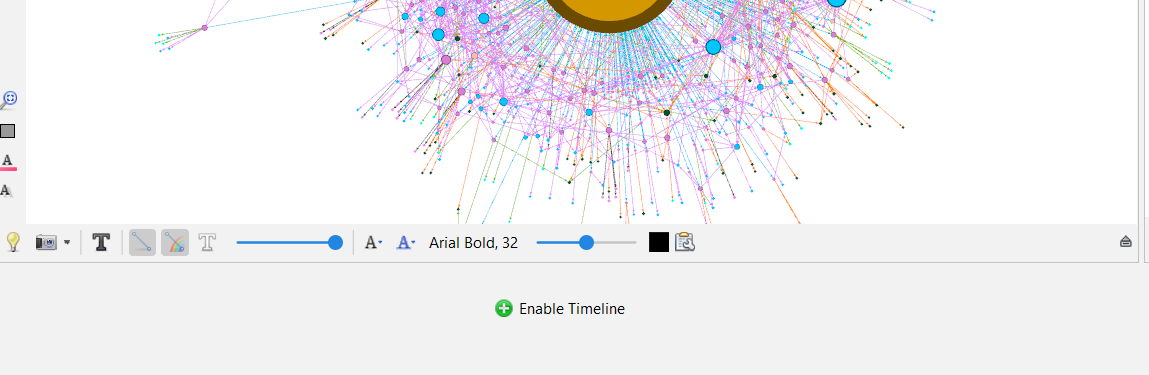

Als we op de knop 'enable timeline' drukken, opent een venster aan de rechterkant (het filtermenu). Dit is omdat de tijdlijn eigenlijk werkt zoals een filter. Ook onderaan verschijnt er een tijdslijn, waarmee we verschillende periodes kunnen bekijken doorheen de data.

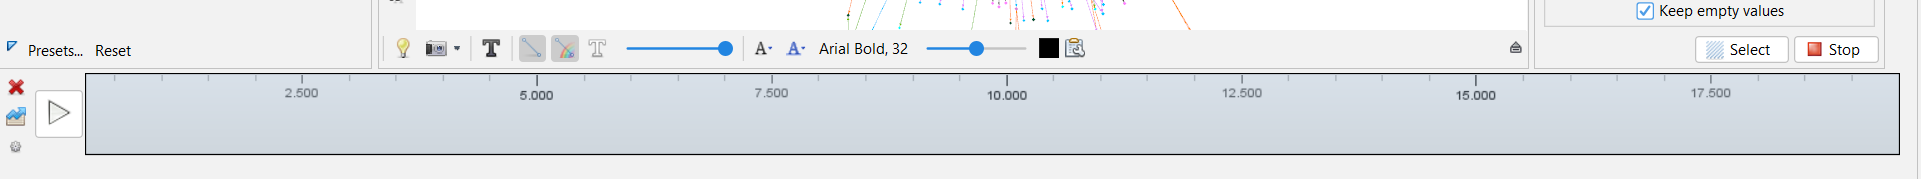

Belangrijk om te weten ook is dat na de activitatie van de tijdslijn nog een interval geselecteerd moet worden. Dat kan je doen door de linker- en rechterkant van de selectie te slepen naar de gewenste tijd.

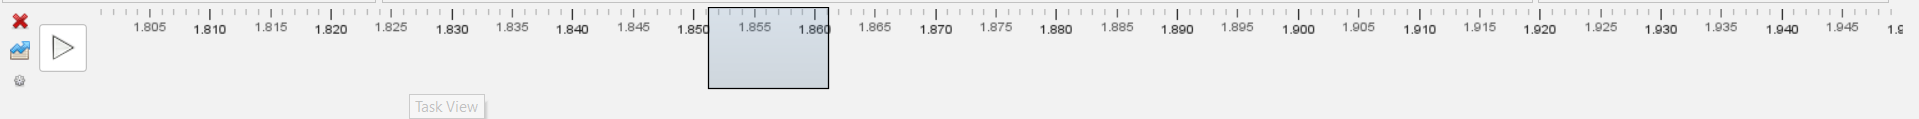

Tot slot kun je de tijdsintervallen ook aanpassen met de knoppen aan de linkerkant van de afspeelknop onderaan. Hier kun je kiezen voor 'custom time bounds & interval'. 'Bounds' staat voor de uiterste limieten die je wil zichtbaar maken van de tijdlijn. 'Interval' verwijst naar de periode die je selecteert (het blauwe vakje hierboven). Het interval toont de resultaten van deze periode.


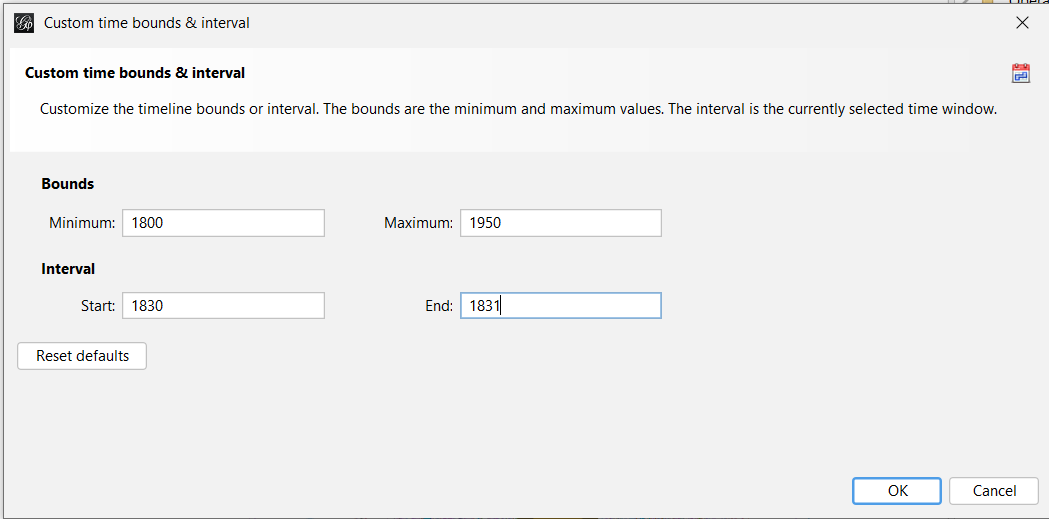

Omdat veel data geen info hadden hebben we deze aangevuld met een fictieve datum: We hebben er hier voor gekozen om het startjaar in te stellen op de geboortedatum van Guido Gezelle (1830) en het eindjaar op het jaar van overlijden (1899).

Een kleine tip voor het gebruik van de tijdslijn: als je de starttijd en eindttijd op 1831 zet, en vervolgens op de 'start animatie'-knop drukt, zul je de relaties doorheen de tijd zien verschijnen.

**Importeren nieuw bestand met nodes of edges**

Als je later toch de data van de nodes of edges wil aanpassen in de originele spreadsheets, kun je de aangepaste versies eenvoudig opnieuw downloaden vanuit Excel of Google Spreadsheets en inladen via 'Data Laboratory'-'import spreadsheet' in Gephi. Je kan daarvoor eerst alle nodes of edges selecteren (ctrl+a) in Gephi en dan verwijderen. Vervolgens kun je de nieuwe set selecteren en inladen, zoals je deed na de opstart van Gephi.

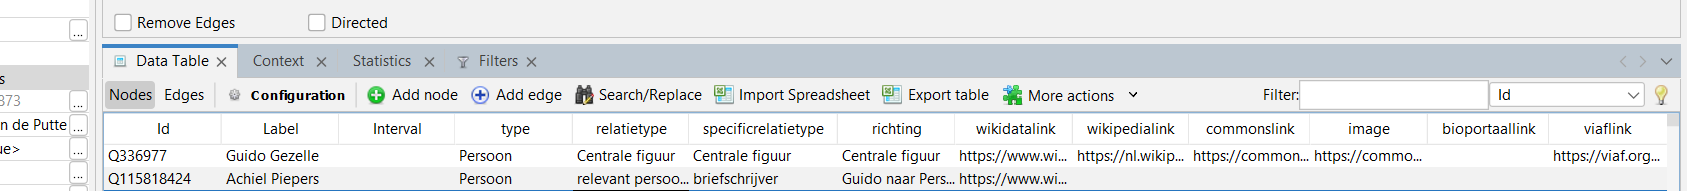

##SIGMA/JAVA

In de vorige vier visualisaties werd steeds gebruik gemaakt van de plugin Sigma Exporter om de visualisatie te exporteren (zie andere handleidingen). Hier hebben we geopteerd voor een andere wijze van export, omdat we met een complexe visualisatie met een tijdlijn willen visualiseren, en Sigma niet voldoet aan de criteria om dit op functionele wijze te kunnen doen. We hebben vele verschillende plugins uitgeprobeerd, maar liep steeds opnieuw vast. We konden helaas geen kant-en-klare bestaande oplossingen vinden.

Om die reden hebbben we besloten om een nieuwe interface op te bouwen op basis van de kennis die we in de vorige visualisaties hebben opgedaan. Dit komt er simpelweg op neer dat we een html-script zullen schrijven om de data van Gephi te visualiseren. Met wat opzoekwerk kwamen we terecht bij javascript en vis.

**Exporteren nodes en edges-bestand vanuit Gephi**

Eerst en vooral is het belangrijk dat we het nodes-bestand en het edges-bestand kunnen exporteren uit Gephi. Deze twee bestanden zullen we later opladen op Github. De interface die we verderop zullen uitwerken, zal gebruik maken van deze twee bestanden. Het is daarom belangrijk dat we ze met de bewerkingen vanuit Gephi kunnen verkrijgen. Hieronder tonen we hoe de bestanden gemakkelijk en correct geëxporteerd kunnen worden.

Eerst en vooral gaan we naar het menu 'data laboratory'. Vervolgens klik je op 'export table'. Geef het document een toepasselijke naam en klik op het vakje 'opties'. Hier is het belangrijk het de knopentabel (nodes) of de tabel met verbindingen (edges) te selecteren. In de afbeelding hieronder worden de stappen nogmaals weergegeven.

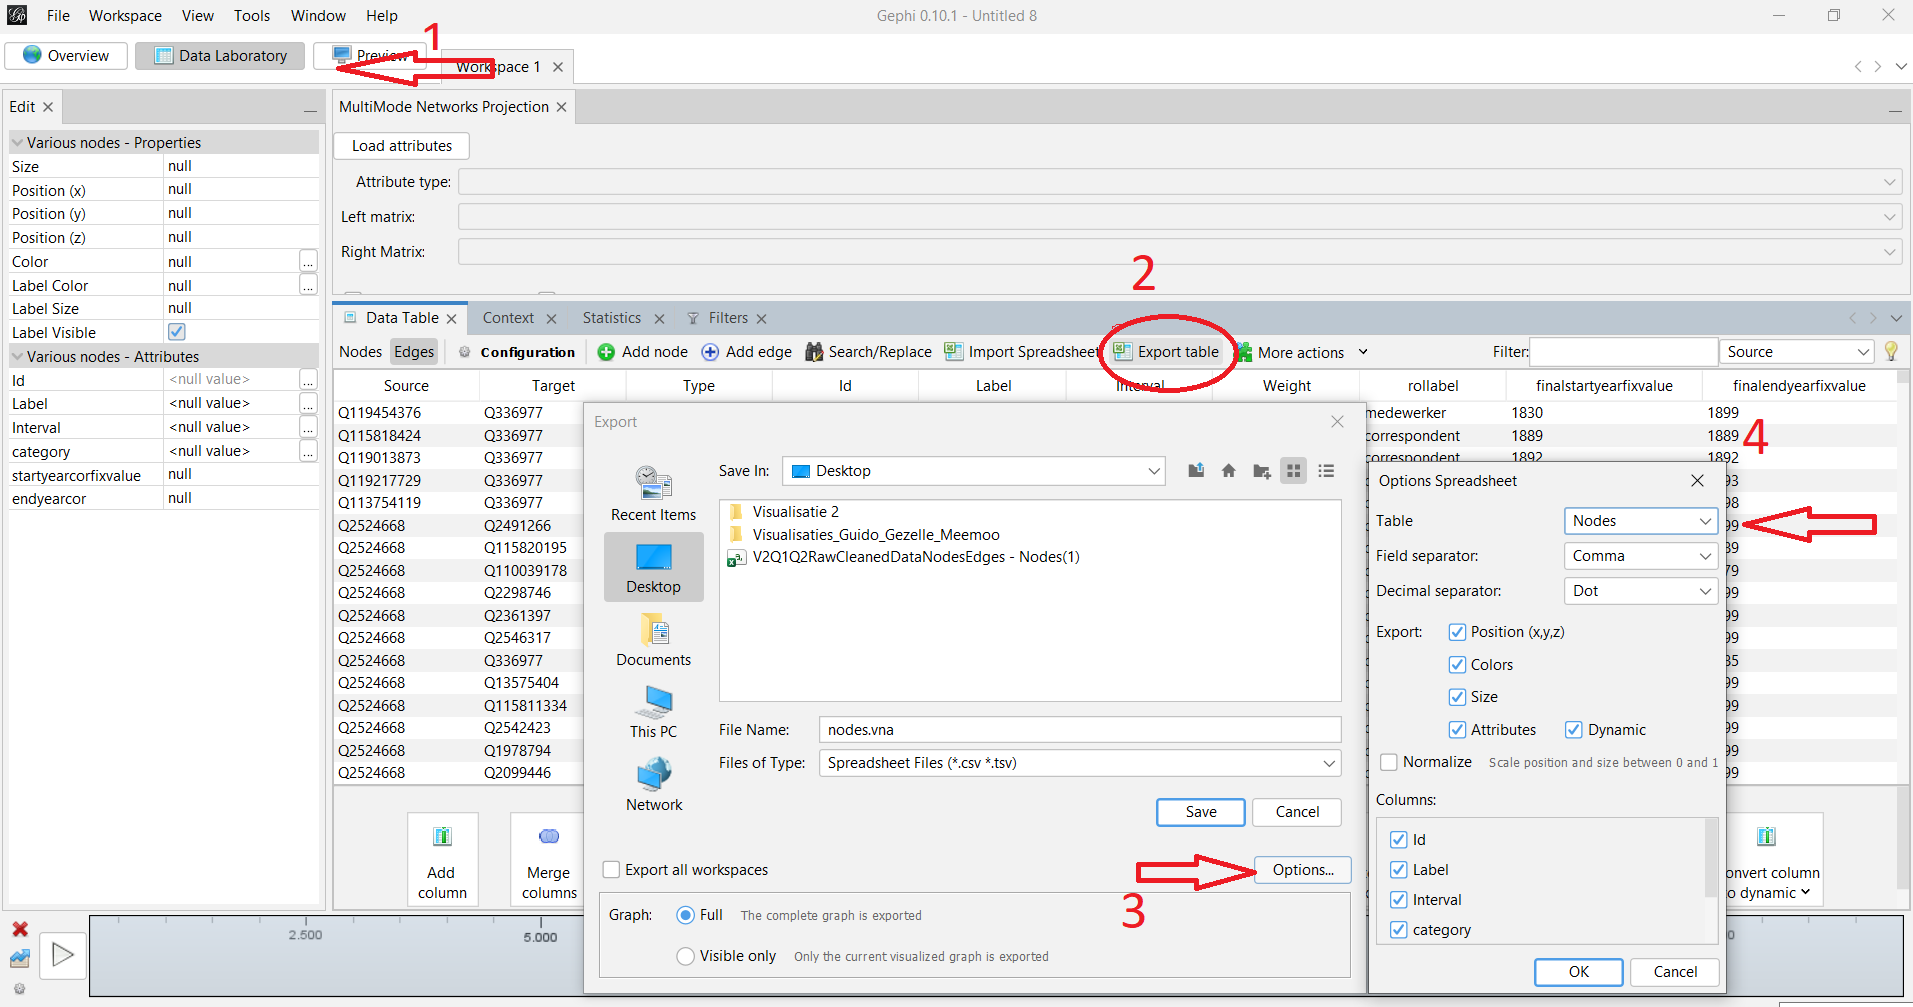

**Basisscript**

Met de hulp van Gemini 3 zijn we aan de slag gegaan om een interface te bouwen die het nodes-bestand en edges-bestand kan visualiseren.

de prompt: "Genereer de minimale HTML-code voor een netwerkvisualisatie op basis van deze visualisatie in Gephi (toevoeging GEPX-bestand V5). Ik las dat ' vis'en 'papaparse' handige tools zijn om dit te coderen! Ik zou graag de functionaliteit van een timeline krijgen: een controlebalk met inputvelden (startYear en endYear) om knooppunten en randen te filteren op basis van de startYear en endYear kolommen in de data.



Hier beginnen we met de basis: data laden en het netwerk één keer tekenen.
Deze code bevat alleen de essentiële onderdelen: de HTML-structuur, de bibliotheken, minimale styling, en de JavaScript-logica om de nodes.csv en edges.csv te laden en direct te visualiseren. Tot slot bevat deze code ook een tijdsfiltering voor de visualisatie. Het maakt gebruikt van vis'en 'papaparse' als tools om de visualisatie te maken.

In [ ]:
<!DOCTYPE html>
<html>
<head>
    <title>Gezelle Netwerk - Met Tijdsfilter</title>

    <script type="text/javascript" src="https://unpkg.com/vis-network@9.1.2/standalone/umd/vis-network.min.js"></script>
    <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/PapaParse/5.4.1/papaparse.min.js"></script>

    <style>
        /* Minimale Stijlen */
        #mynetwork {
            width: 100%;
            height: 80vh;
            min-height: 600px;
            border: 1px solid lightgray;
        }
        body {
            font-family: Arial, sans-serif;
            padding: 20px;
        }
        .controls {
            margin-bottom: 20px;
            padding: 15px;
            border: 1px solid #ddd;
            background-color: #f9f9f9;
            display: flex;
            align-items: center;
        }
        .controls label, .controls input { margin-right: 20px; }
        #resetButton {
            padding: 10px 15px;
            background-color: #007bff;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            margin-left: auto;
        }
        #resetButton:hover { background-color: #0056b3; }
    </style>
</head>
<body>

    <h1>Netwerk Visualisatie Guido Gezelle (Met Tijdsfilter)</h1>

    <div class="controls">
        <label for="startYear">Start Jaar:</label>
        <input type="number" id="startYear" value="1870" min="1800" max="1950" onchange="filterAndDraw()">

        <label for="endYear">Eind Jaar:</label>
        <input type="number" id="endYear" value="1890" min="1800" max="1950" onchange="filterAndDraw()">

        <p style="margin-top: 0; margin-right: 20px;">Gefilterde knooppunten: <strong id="nodeCount">0</strong> | Gefilterde randen: <strong id="edgeCount">0</strong></p>

        <button id="resetButton" onclick="filterAndDraw()">Herteken Grafiek</button>
    </div>

    <div id="mynetwork"></div>

    <script type="text/javascript">
        let allNodes = []; // Opslag voor alle ruwe nodes
        let allEdges = []; // Opslag voor alle ruwe edges
        let network = null;
        let nodesDataSet = null; // De Vis.js DataSet voor nodes
        let edgesDataSet = null; // De Vis.js DataSet voor edges
        const container = document.getElementById('mynetwork');

        // --- Vis.js Opties ---
        const options = {
            nodes: { shape: 'dot', font: { size: 14, color: '#333' }, borderWidth: 2 },
            edges: { arrows: 'to', color: { inherit: true }, smooth: { type: 'continuous' } },
            physics: { enabled: false /* Gebruikt de X/Y coördinaten uit het CSV */ }
        };

        // --------------------------------------------------------------------
        // --- Data Functies ---
        // --------------------------------------------------------------------

        /**
         * Hulpfunctie om een lokaal CSV-bestand te parsen met PapaParse.
         */
        function parseCSV(url) {
            return new Promise((resolve, reject) => {
                Papa.parse(url, {
                    download: true,
                    header: true,
                    skipEmptyLines: true,
                    dynamicTyping: true,
                    complete: (results) => {
                        if (results.data.length === 0) {
                            reject(new Error(`CSV-bestand ${url} is leeg.`));
                        }
                        resolve(results.data);
                    },
                    error: (error) => reject(error)
                });
            });
        }

        /**
         * Laadt de CSV-bestanden en slaat de volledige dataset op.
         */
        async function loadData() {
            try {
                // 1. Ruwe data Laden
                const nodesDataRaw = await parseCSV('nodes.csv');
                const edgesDataRaw = await parseCSV('edges.csv');

                // 2. Data Mappen en Opslaan
                allNodes = nodesDataRaw.map(d => ({
                    id: d.Id,
                    label: d.Label,
                    group: d.category,
                    color: d.Color,
                    size: parseFloat(d.Size) || 15,
                    x: parseFloat(d.X),
                    y: parseFloat(d.Y),
                    fixed: true,
                    title: `Naam: ${d.Label}\nType: ${d.category}`,
                    // Nodig voor de tijdsfilter, hoewel nodes niet direct gefilterd worden
                    startYear: parseInt(d.startyearcorfixvalue),
                    endYear: parseInt(d.endyearcor)
                }));

                allEdges = edgesDataRaw.map(d => ({
                    id: d.Id,
                    from: d.Source,
                    to: d.Target,
                    color: d.Color,
                    title: `Relatie: ${d.rollabel}`,
                    // CRUCIAAL voor de tijdsfilter
                    startYear: parseInt(d.finalstartyearfixvalue),
                    endYear: parseInt(d.finalendyearfixvalue),
                    label: d.rollabel // Handig voor toekomstige legende
                }));

                // 3. Initialiseer de DataSets
                nodesDataSet = new vis.DataSet();
                edgesDataSet = new vis.DataSet();

                // 4. Eerste weergave
                filterAndDraw();

            } catch (error) {
                console.error("Fout bij het laden van de bestanden:", error);
                container.innerHTML = "<h2>Data Laadfout: Netwerk is leeg</h2><p>Controleer of de bestanden **'nodes.csv'** en **'edges.csv'** in **dezelfde map** staan.</p>";
            }
        }

        // --------------------------------------------------------------------
        // --- Filtering en Drawing Functies ---
        // --------------------------------------------------------------------

        /**
         * Filtert de data op basis van het ingestelde jaarbereik en tekent het netwerk.
         */
        function filterAndDraw() {
            const startYear = parseInt(document.getElementById('startYear').value);
            const endYear = parseInt(document.getElementById('endYear').value);

            if (isNaN(startYear) || isNaN(endYear)) return;

            // 1. Tijdfiltering (Edges)
            let filteredEdges = allEdges.filter(edge => {
                // Check op overlap: rand is actief als het begint voor het einde van de filter
                // en eindigt na het begin van de filter.
                return edge.startYear <= endYear && edge.endYear >= startYear;
            });

            // 2. Nodes bepalen op basis van de gefilterde Edges
            let connectedNodeIds = new Set();
            filteredEdges.forEach(edge => {
                connectedNodeIds.add(edge.from);
                connectedNodeIds.add(edge.to);
            });

            let filteredNodes = allNodes.filter(node => connectedNodeIds.has(node.id));

            // 3. Update de tellers
            document.getElementById('nodeCount').textContent = filteredNodes.length;
            document.getElementById('edgeCount').textContent = filteredEdges.length;

            // 4. Update de Vis.js DataSets
            nodesDataSet.clear();
            nodesDataSet.add(filteredNodes);
            edgesDataSet.clear();
            edgesDataSet.add(filteredEdges);

            // 5. Initialiseer/Update het Netwerk
            const data = { nodes: nodesDataSet, edges: edgesDataSet };

            if (network) {
                // Als het netwerk al bestaat, update de data
                network.setData(data);
                network.fit();
            } else {
                // Anders, creëer het netwerk voor het eerst
                network = new vis.Network(container, data, options);
                network.fit();
            }
        }

        // Start het laadproces
        loadData();
    </script>

</body>
</html>

Als we dit opladen op Github (zie verder), dan krijgen we deze visualisatie:

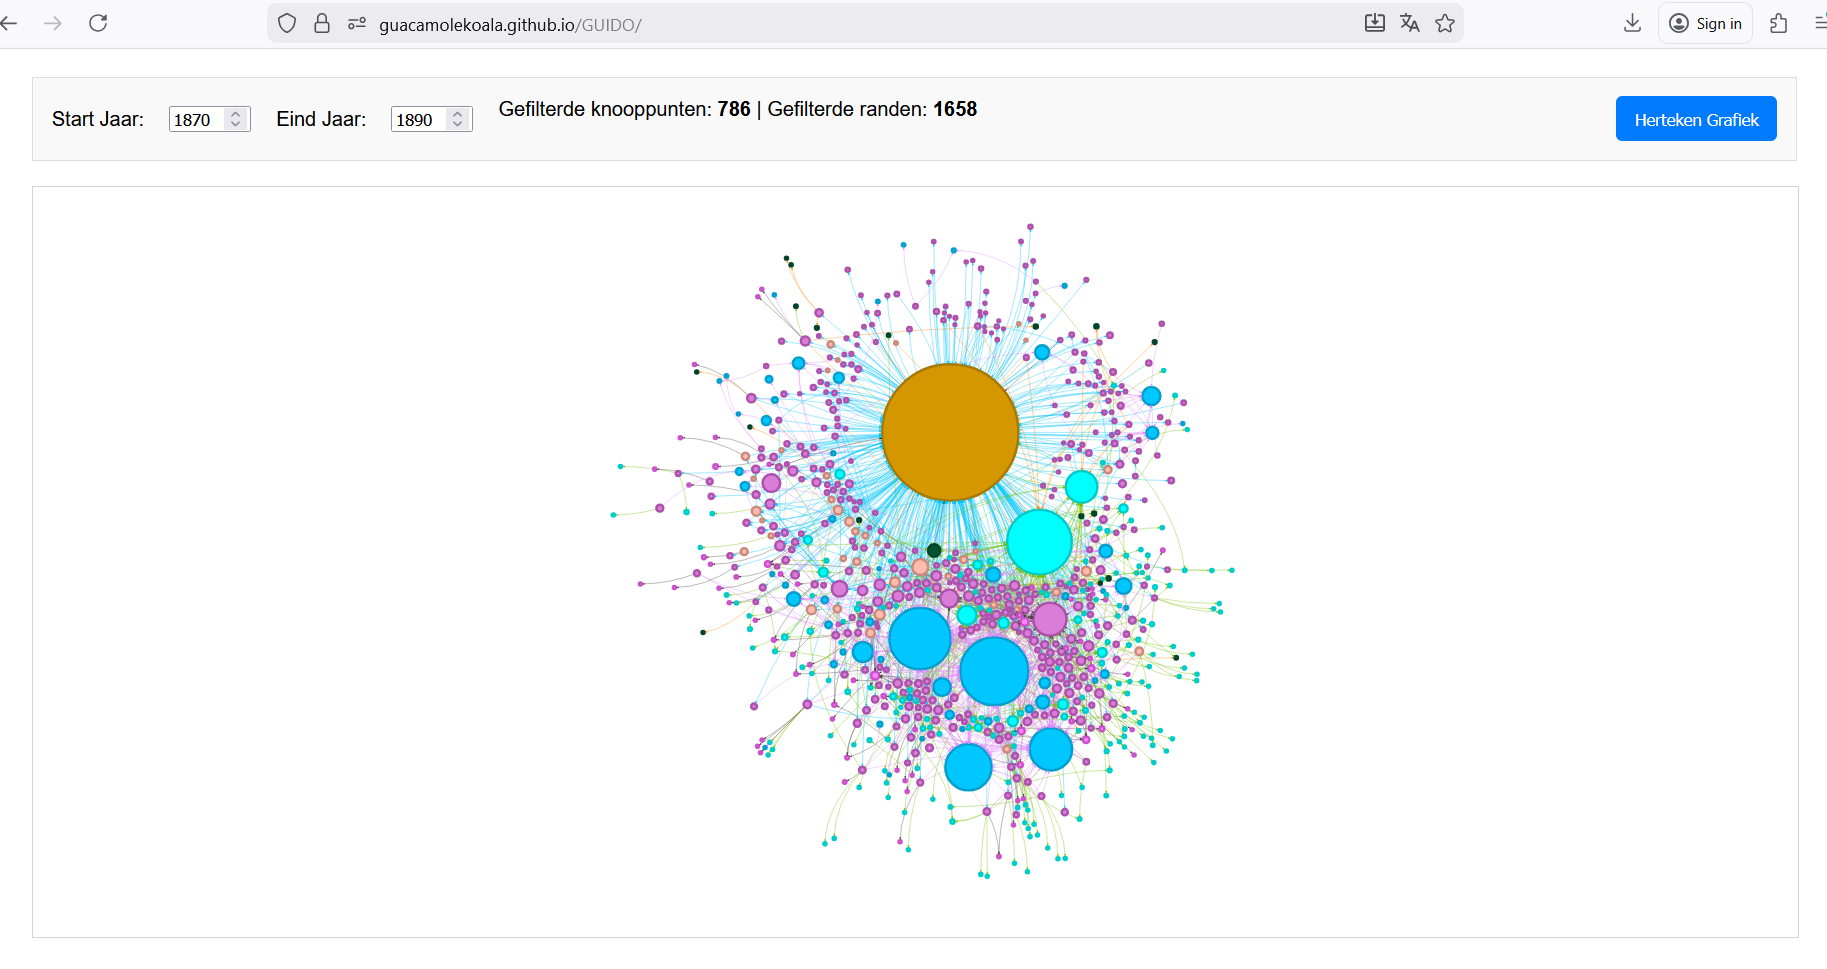

## UPLOAD GITHUB

Vervolgens wilden we deze visualisatie interactief kunnen aanbieden op een website. Via github kunnen we deze documenten opladen en omzetten in een webpagina. Op zich is dit niet erg moeilijk eens men een account heeft op Github. Eerst en vooral moet er een repository gemaakt worden. Dit repository kan vervolgens omgezet worden tot een Github-page. Via de link naar de page krijg je de visualisatie te zien.

**repository**

Eerst en vooral maak je dus een nieuw repository aan op Github. Geef het een toepasselijke naam, bv 'VisualisatieGezelle1'. Vervolgens wordt de map met bestanden.

Aavullen!

Klik op 'add files/upload new files'. Dit lukt mogelijk enkel in Chrome. Sommige browsers nemen niet alle bestanden over. Eens het opladen klaar is, kan je op 'commit' drukken. De bestanden zitten nu in het repository

**Github page**

nu zullen we van het repository een webpagina maken. Daarvoor klikken we op het 'repository' en gaan vervolgens naar de 'settings'. Daar kiezen we voor 'pages'. Onder 'build and deployment' selecteer je 'main' als branch en in het vak ernaast voor 'root'. Klik vervolgens op 'save'. Wacht enkele minuten en herlaad de pagina. Je zult nu een link te zien krijgen waarop de webpagina te bekijken is:

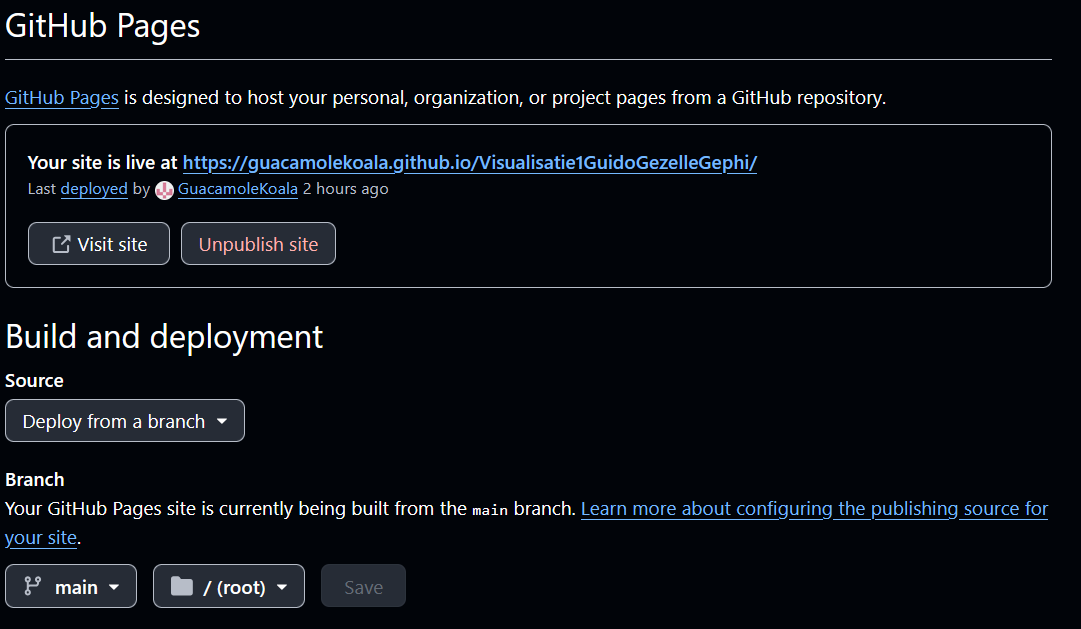

**Version control**

Je kan de code die opgeladen is, ook makkelijk aanpassen via het platform via Github. Op die manier kan je ook een controle/geschiedenis opbouwen aan veranderingen in je code. Op die manier kan je ook terugkeren naar een eerder moment, moest er iets fout lopen.

Opmerking:
Op elk moment kan de dataset aangepast worden door op github naar het bestand 'data.json' te gaan en dit te vervangen door een nieuwe export vanuit Gephi (of elders).
De titel, korte en uitgebreide beschrijving, enzovoort kunnen eenvoudig aangepast worden in het config.json of index.html via Github of een andere editor.
Ook de algemene werking van de interface kan aangepast worden via het main.js- bestand. Ook dit kan vervangen worden of aangevuld worden waar nodig met nieuwe code.

**Code aanpassen op Github:**



Je kan code van de bestanden gemakkelijk aanpassen via Github. Ga daarvoor naar de repository die je eerder hebt gemaakt en bekijk de bestanden door erop te klikken.

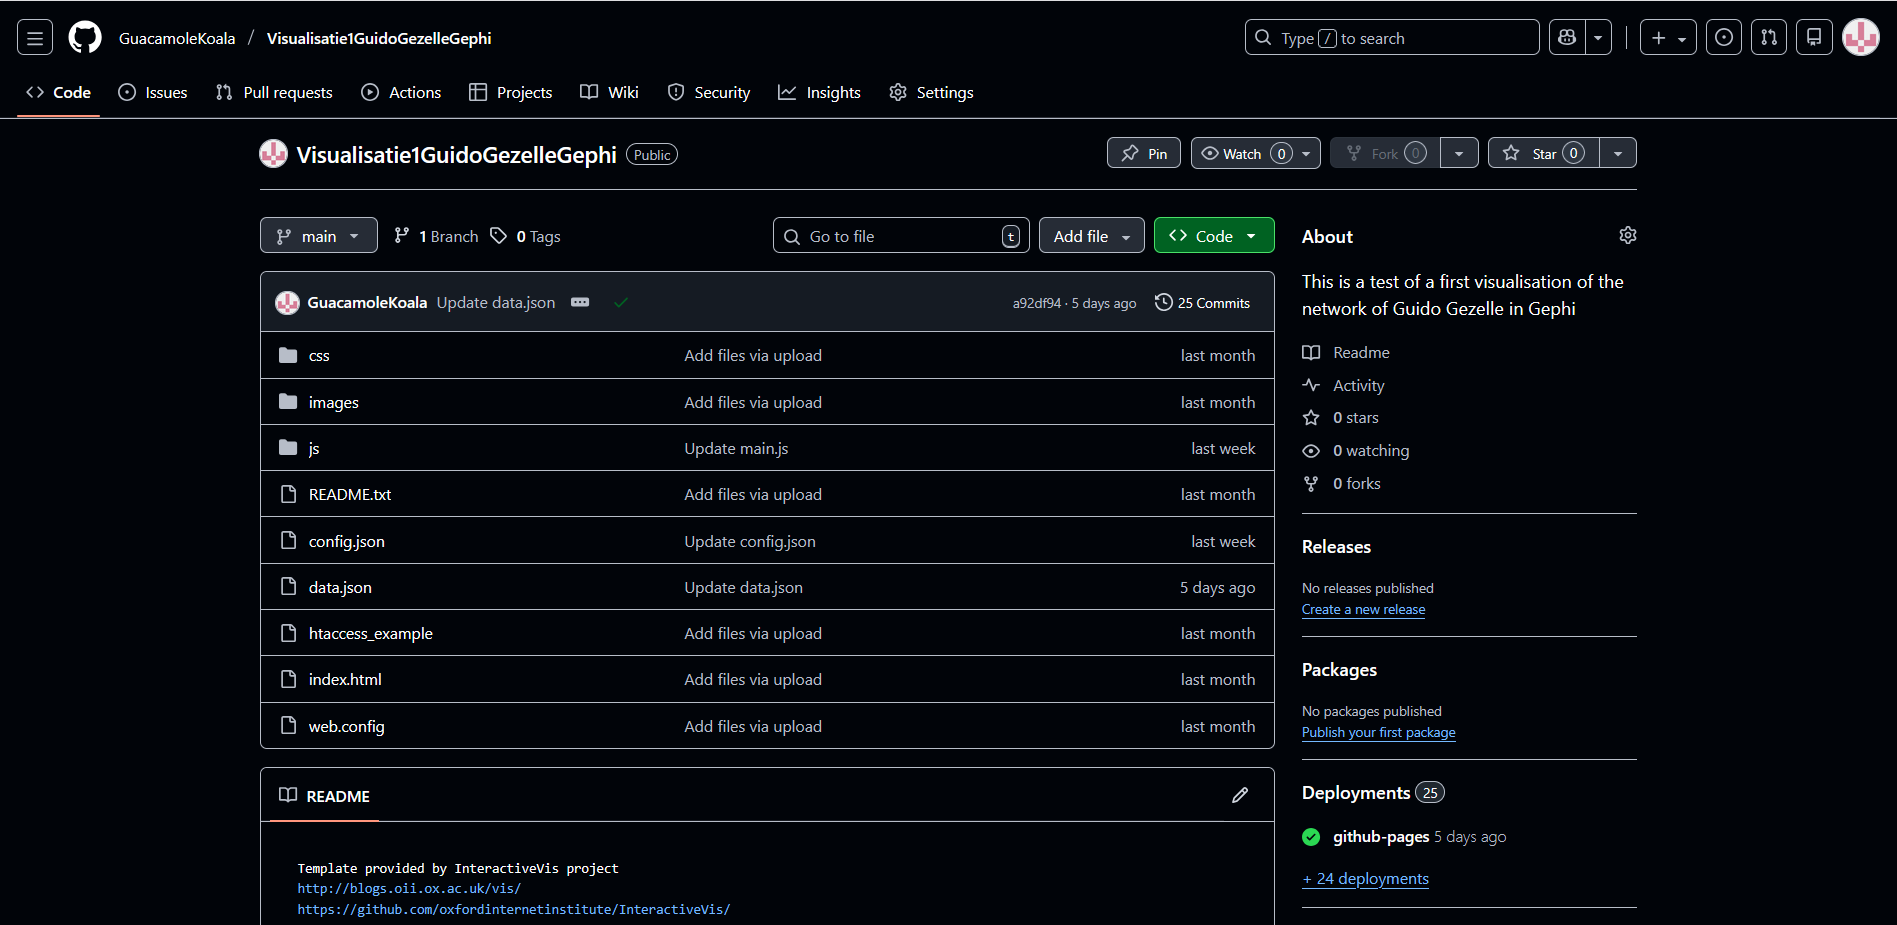

Als je rechts op het potlood-icoontje klikt, kun je de code direct aanpassen.

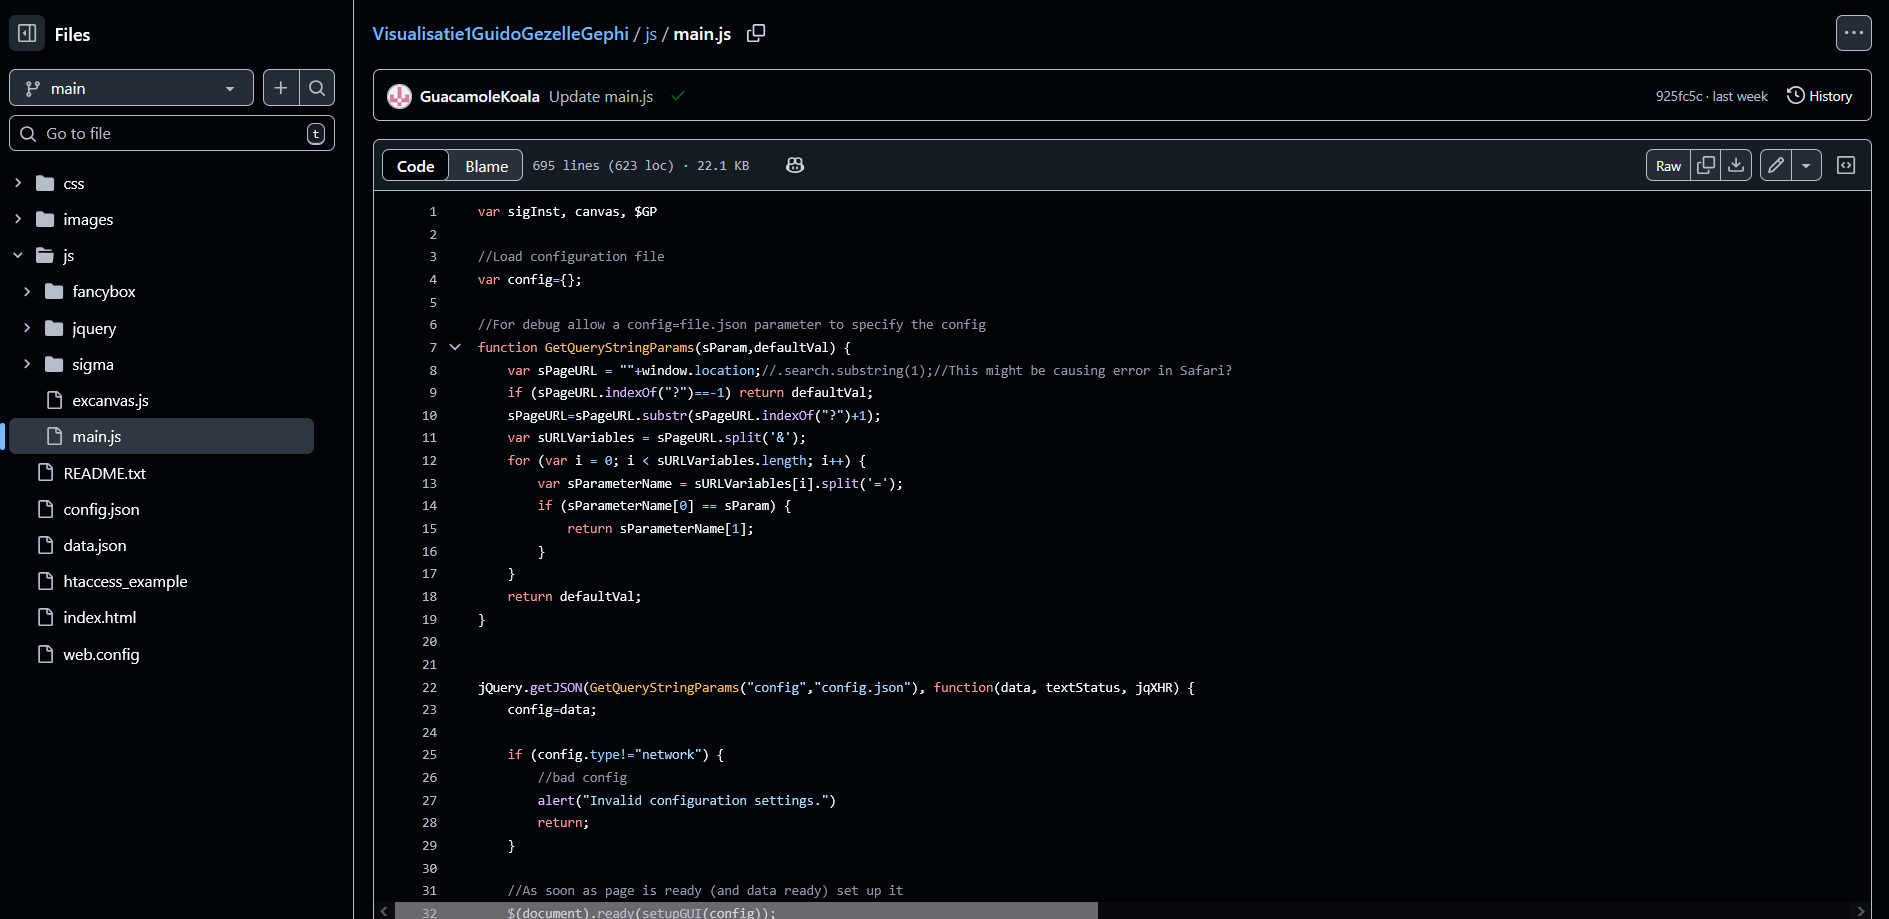

Na de aanpassingen druk je op 'commit changes'. Hier kun je ook een nota toevoegen van wat je precies hebt gedaan of verbeterd. Dit is belangrijk voor de controle van versies, indien er iets misgaat bijvoorbeeld.

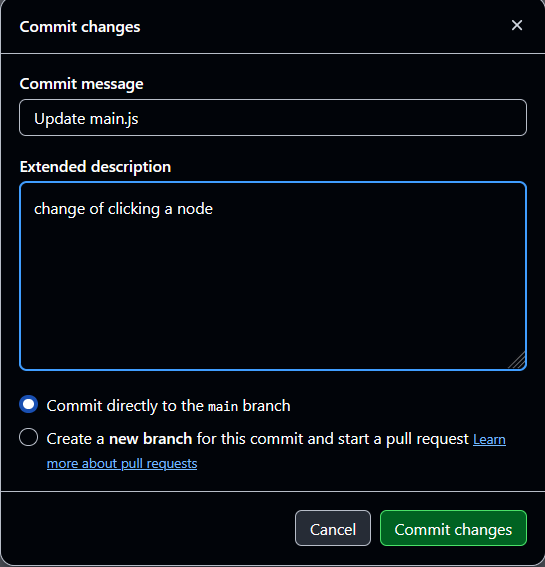

Na een paar minuten kun je de aanpassingen zien op de webpagina. Soms moet je opletten dat de browser niet een oude versie blijft herladen (door cache of cookies). Een optie is om even te wachten of in tussentijd een andere browser te proberen.

##AANPASSEN SCRIPT

Vervolgens zijn we gaan prompten om verschillende functionaliteit aan deze De visualisatie moet de volgende interactieve functionaliteiten bevatten:

1) Interactieve Legende: Een uitschuifbaar overlay-paneel dat automatisch de unieke categorieën (nodes: group, edges: label) uit de data verzamelt. Gebruikers moeten op een categorie kunnen klikken om de visualisatie hierop te filteren. Dit moet ook een sluitknop 'x' hebben.

2) Node Interactie: Wanneer op een knooppunt wordt geklikt, moeten de directe buren en de verbonden randen worden gehighlight. Alle andere elementen moeten dimmen (minder zichtbaar worden).

3) Info Zijpaneel: Een schuifbaar zijpaneel dat verschijnt wanneer een knooppunt is geselecteerd, en dat alle inkomende en uitgaande relaties van die specifieke node toont. Dit moet ook een sluitknop 'x' hebben.

4) Vaste Layout: De layout van het netwerk moet gebaseerd zijn op de X en Y coördinaten uit het CSV-bestand, met de fysica-motor van vis.js uitgeschakeld

5) Reset knop: indien er iets vastloopt, willen we dat door op deze knop te drukken, de originele visualisatie centraal getoond wordt.

6) Beschrijving: We willen ook een knop waarachter we een beschrijving/meer info omtrent de visualisatie kunnen plaatsen.

7) Tijdsanimatie ⏱️ (Play Button): Een nieuwe knop #playPauseButton is toegevoegd. Nieuwe JavaScript-functies (startAnimation, stopAnimation, playAnimationStep) regelen de weergave door het endYear automatisch stapsgewijs te verhogen. Een aanpasbare stapgrootte (yearStep) is geïntroduceerd. Een weergave (#activeEndYear) toont het huidige geanimeerde jaartal.

8) Bugfix (Deselectie):De functie handleNodeClick is aangepast om expliciet de Vis.js interne selectie (network.unselectAll()) te resetten wanneer een reeds geselecteerde knoop wordt aangeklikt of wanneer op de achtergrond wordt geklikt. Dit lost de "glitchy" toestand op waarbij alleen randen zichtbaar bleven.

9) layout van de knoppen: Eerste Lijn (Toolbar Boven): Deze lijn bevat de hoofdfilters en resetfunctionaliteit. 1) Tijdlijn Selector: Startjaar - Eindjaar; 2) Filter Knoppen: Gefilterde knopen (Nodes) en gefilterde randen (Edges); 3)Actie Knop: Resetknop. De Tweede Lijn (Animatie en Hulp) bevat de animatie en de hulpsecties. 1)Animatie Bediening: Animatieknop (Start/Stop); stapgrootte (bijv. per jaar, per 5 jaar); actief jaar (Weergave van het huidige jaar in de animatie); 2) Hulp Knoppen: legende-knop en info-knop.

Volledige nieuwe code:

In [ ]:
<!DOCTYPE html>
<html>
<head>
    <title>Gezelle Netwerk Visualisatie - Compleet</title>
    <script type="text/javascript" src="https://unpkg.com/vis-network@9.1.2/standalone/umd/vis-network.min.js"></script>
    <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/PapaParse/5.4.1/papaparse.min.js"></script>

    <style>
        /* FIX 1: Zorgt dat de body de volledige viewport-hoogte inneemt */
        html, body {
            height: 100%;
            margin: 0;
            overflow: hidden; /* Voorkomt scrollbars */
        }

        /* Basisstijlen voor de container */
        #mynetwork {
            width: 100%;
            flex-grow: 1; /* Vult de resterende hoogte */
            min-height: 500px;
            border: 1px solid lightgray;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }
        body {
            font-family: Arial, sans-serif;
            padding: 20px;
            position: relative;
            display: flex;
            flex-direction: column;
            box-sizing: border-box;
        }

        /* Stijlen voor de controlebalk */
        .controls {
            margin-bottom: 15px;
            padding: 15px;
            border: 1px solid #ddd;
            background-color: #f9f9f9;
            display: flex;
            flex-direction: column;
            flex-wrap: wrap;
            flex-shrink: 0;
        }
        .control-row {
            display: flex;
            align-items: center;
            width: 100%;
            margin-bottom: 10px;
        }
        .controls label, .controls input, .controls select { margin-right: 15px; }
        .controls p { margin: 0 20px 0 0; }

        /* Stijlen voor de functionele knoppen */
        .functional-button {
            padding: 10px 15px;
            color: white;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            margin-left: 10px;
            transition: background-color 0.2s;
        }

        /* Specifieke knop stijlen */
        #playPauseButton {
            background-color: #ff9800;
            margin-right: 25px; /* Ruimte rechts */
        }
        #playPauseButton:hover { background-color: #e68900; }

        #resetButton {
            background-color: #007bff;
            margin-left: auto;
            margin-right: 25px; /* Ruimte rechts (whitespace) */
        }
        #resetButton:hover { background-color: #0056b3; }

        #legendToggleButton, #infoButton { background-color: #28a745; }
        #legendToggleButton:hover, #infoButton:hover { background-color: #1e7e34; }

        /* Overlays */
        .overlay-container {
            position: absolute;
            top: 100px;
            right: 20px;
            z-index: 1000;
            background: white;
            padding: 20px;
            border: 1px solid #ccc;
            box-shadow: 0 4px 8px rgba(0,0,0,0.2);
            max-width: 350px;
            max-height: 450px;
            overflow-y: auto;
            transition: opacity 0.3s;
        }
        .close-button {
            position: absolute;
            top: 10px;
            right: 15px;
            font-size: 24px;
            font-weight: bold;
            cursor: pointer;
            background: transparent;
            border: none;
            line-height: 1;
            color: #333;
            padding: 5px;
            z-index: 1002;
        }
        .close-button:hover { color: #dc3545; }
        .overlay-container h3 { padding-right: 30px; }

        /* Legende */
        #legendContainer { display: none; }
        .legend-item {
            display: flex;
            align-items: center;
            margin-bottom: 5px;
            padding: 5px;
            border-radius: 3px;
            cursor: pointer;
            transition: background-color 0.1s;
        }
        .legend-item:hover { background-color: #e9ecef; }
        .legend-item.active {
            font-weight: bold;
            background-color: #ffe0b2;
            border: 1px dashed #ff9800;
        }
        .legend-color {
            min-width: 15px;
            height: 15px;
            border-radius: 50%;
            margin-right: 10px;
            border: 1px solid #333;
        }
        .legend-edge {
            min-width: 30px;
            height: 3px;
            margin-right: 10px;
        }

        /* Info Paneel */
        #nodeInfoPanel {
            position: fixed;
            top: 0;
            right: -300px;
            width: 300px;
            height: 100%;
            background-color: #f8f9fa;
            border-left: 1px solid #ccc;
            box-shadow: -4px 0 8px rgba(0,0,0,0.1);
            z-index: 1001;
            transition: right 0.3s ease-in-out;
            padding: 20px;
            overflow-y: auto;
            padding-top: 50px;
        }
        #nodeInfoPanel h2 {
            margin-top: 0;
            font-size: 1.5rem;
            border-bottom: 2px solid #007bff;
            padding-bottom: 10px;
        }
        #nodeInfoPanel h4 {
            margin-top: 15px;
            margin-bottom: 5px;
            color: #555;
        }
        #nodeInfoPanel ul {
            list-style-type: none;
            padding-left: 0;
        }
        #nodeInfoPanel li {
            margin-bottom: 3px;
            font-size: 0.9rem;
        }
    </style>
</head>
<body>

    <h1>Visualisatie 5: Netwerk van Guido Gezelle over de tijd</h1>

    <div class="controls">
        <div class="control-row">
            <label for="startYear">Start Jaar:</label>
            <input type="number" id="startYear" value="1870" min="1800" max="1950" onchange="filterAndDraw(); stopAnimation();">

            <label for="endYear">Eind Jaar:</label>
            <input type="number" id="endYear" value="1890" min="1800" max="1950" onchange="filterAndDraw(); stopAnimation();">

            <p>Gefilterde knooppunten: <strong id="nodeCount">0</strong> | Gefilterde randen: <strong id="edgeCount">0</strong></p>

            <button id="resetButton" class="functional-button" onclick="resetView()">Reset Filters & View</button>
        </div>

        <div class="control-row" style="margin-bottom: 0;">
            <button id="playPauseButton" class="functional-button" onclick="toggleAnimation()">▶ Start Animatie</button>

            <label for="yearStep">Stapgrootte (Jaren):</label>
            <select id="yearStep" style="padding: 8px;">
                <option value="1">1 Jaar</option>
                <option value="5" selected>5 Jaren</option>
                <option value="10">10 Jaren</option>
            </select>

            <p style="margin-right: 30px;">Actief Jaar: <strong id="activeEndYear">1890</strong></p>

            <button id="legendToggleButton" class="functional-button" onclick="toggleLegend()">Legende Tonen</button>
            <button id="infoButton" class="functional-button" onclick="showInfo()">Meer Info</button>
        </div>
    </div>

    <div id="mynetwork"></div>

    <div id="legendContainer" class="overlay-container">
        <h3>Legende</h3>
        <button class="close-button" onclick="toggleLegend(true)">&times;</button>
        <p>Klik op een categorie om te filteren.</p>
        <div id="legendList">
        </div>
    </div>

    <div id="nodeInfoPanel">
        <button class="close-button" onclick="updateInfoPanel(null)">&times;</button>
        <div id="nodeInfoContent">
        </div>
    </div>

    <script type="text/javascript">
        let allNodes = [];
        let allEdges = [];
        let network = null;
        let originalNodesData = null;
        let originalEdgesData = null;
        const container = document.getElementById('mynetwork');
        let selectedNode = null;
        let currentCategoryFilter = { category: null, isNode: null };

        // --- Animatie State ---
        let isPlaying = false;
        let animationInterval = null;
        const ANIMATION_MIN_YEAR = 1800;
        const ANIMATION_MAX_YEAR = 1950;
        const ANIMATION_SPEED_MS = 500;

        // --- Vis.js Options ---
        const options = {
            nodes: {
                shape: 'dot',
                font: { size: 14, color: '#333' },
                borderWidth: 2
            },
            edges: {
                arrows: 'to',
                color: { inherit: true },
                smooth: { type: 'continuous' }
            },
            physics: { enabled: false }
        };

        // --- Data Laden ---
        async function loadData() {
            try {
                const nodesData = await parseCSV('nodes.csv');
                allNodes = nodesData.map(d => ({
                    id: d.Id,
                    label: d.Label,
                    group: d.category,
                    title: `Naam: ${d.Label}\nType: ${d.category}\nStart: ${d.startyearcorfixvalue}\nEind: ${d.endyearcor}`,
                    startYear: parseInt(d.startyearcorfixvalue),
                    endYear: parseInt(d.endyearcor),
                    size: parseFloat(d.Size) || 15,
                    color: d.Color,
                    x: parseFloat(d.X),
                    y: parseFloat(d.Y),
                    fixed: true
                }));

                const edgesData = await parseCSV('edges.csv');
                allEdges = edgesData.map(d => ({
                    id: d.Id,
                    from: d.Source,
                    to: d.Target,
                    label: d.rollabel,
                    title: `Relatie: ${d.rollabel}\nJaar: ${d.finalstartyearfixvalue}-${d.finalendyearfixvalue}`,
                    startYear: parseInt(d.finalstartyearfixvalue),
                    endYear: parseInt(d.finalendyearfixvalue),
                    color: d.Color
                }));

                document.getElementById('activeEndYear').textContent = document.getElementById('endYear').value;
                filterAndDraw();
                buildLegend();

            } catch (error) {
                console.error("Fout bij het laden van de bestanden:", error);
                container.innerHTML = "<h2>Data Laadfout</h2><p>Controleer de CSV bestanden.</p>";
            }
        }

        function parseCSV(url) {
            return new Promise((resolve, reject) => {
                Papa.parse(url, {
                    download: true, header: true, skipEmptyLines: true, dynamicTyping: true,
                    complete: (results) => resolve(results.data),
                    error: (error) => reject(error)
                });
            });
        }

        // --- Filtering & Drawing ---
        function filterAndDraw() {
            const startYear = parseInt(document.getElementById('startYear').value);
            let endYear = parseInt(document.getElementById('endYear').value);

            if (isPlaying) {
                endYear = parseInt(document.getElementById('activeEndYear').textContent);
                document.getElementById('endYear').value = endYear;
            }

            if (isNaN(startYear) || isNaN(endYear)) return;

            let filteredEdges = allEdges.filter(edge => edge.startYear <= endYear && edge.endYear >= startYear);

            let connectedNodeIds = new Set();
            filteredEdges.forEach(edge => {
                connectedNodeIds.add(edge.from);
                connectedNodeIds.add(edge.to);
            });
            let filteredNodes = allNodes.filter(node => connectedNodeIds.has(node.id));

            if (currentCategoryFilter.category) {
                const category = currentCategoryFilter.category;
                const isNodeCategory = currentCategoryFilter.isNode;
                let finalEdges = filteredEdges;

                if (isNodeCategory) {
                    const categoryNodeIds = new Set(filteredNodes.filter(n => n.group === category).map(n => n.id));
                    finalEdges = filteredEdges.filter(edge => categoryNodeIds.has(edge.from) || categoryNodeIds.has(edge.to));
                } else {
                    finalEdges = filteredEdges.filter(edge => edge.label === category);
                }

                const finalConnectedNodeIds = new Set();
                finalEdges.forEach(edge => {
                    finalConnectedNodeIds.add(edge.from);
                    finalConnectedNodeIds.add(edge.to);
                });

                filteredEdges = finalEdges;
                filteredNodes = allNodes.filter(node => finalConnectedNodeIds.has(node.id));
            }

            document.getElementById('nodeCount').textContent = filteredNodes.length;
            document.getElementById('edgeCount').textContent = filteredEdges.length;

            originalNodesData = new vis.DataSet(filteredNodes);
            originalEdgesData = new vis.DataSet(filteredEdges);

            const data = { nodes: originalNodesData, edges: originalEdgesData };

            if (network) {
                network.setData(data);
                // setTimeout zorgt ervoor dat fit() pas werkt als de layout klaar is
                setTimeout(() => { network.fit(); }, 0);
            } else {
                network = new vis.Network(container, data, options);
                network.on("click", handleNodeClick);
                network.on("doubleClick", handleDoubleClick);
                setTimeout(() => { network.fit(); }, 0);
            }

            selectedNode = null;
            resetHighlighting(false);
            updateInfoPanel(null);
            updateLegendHighlight();
        }

        // --- Animatie ---
        function toggleAnimation() {
            if (isPlaying) stopAnimation(); else startAnimation();
        }

        function startAnimation() {
            if (isPlaying) return;
            isPlaying = true;
            document.getElementById('playPauseButton').textContent = '⏸ Pauzeer Animatie';
            const step = parseInt(document.getElementById('yearStep').value);
            let startYearInput = parseInt(document.getElementById('startYear').value);
            let currentYear = parseInt(document.getElementById('endYear').value);

            if (currentYear < startYearInput) currentYear = startYearInput;

            document.getElementById('activeEndYear').textContent = currentYear;
            document.getElementById('endYear').value = currentYear;
            filterAndDraw();

            animationInterval = setInterval(() => {
                currentYear += step;
                if (currentYear > ANIMATION_MAX_YEAR) {
                    stopAnimation();
                    currentYear = ANIMATION_MAX_YEAR;
                }
                document.getElementById('activeEndYear').textContent = currentYear;
                if (currentYear < startYearInput) { stopAnimation(); return; }
                filterAndDraw();
                if (currentYear >= ANIMATION_MAX_YEAR) stopAnimation();
            }, ANIMATION_SPEED_MS);
        }

        function stopAnimation() {
            if (!isPlaying) return;
            isPlaying = false;
            clearInterval(animationInterval);
            document.getElementById('playPauseButton').textContent = '▶ Start Animatie';
            const finalYear = parseInt(document.getElementById('activeEndYear').textContent);
            document.getElementById('endYear').value = finalYear;
            filterAndDraw();
        }

        // --- Interactie & Fixes ---

        function resetView() {
            currentCategoryFilter = { category: null, isNode: null };
            stopAnimation();
            filterAndDraw();
            network.fit();
        }

        // FIX: Deze functie herstelt de kleuren vanuit de originele data (allNodes/allEdges)
        function resetHighlighting(unselect = true) {
            if (!originalNodesData || !originalEdgesData) return;

            const updatedNodes = [];
            const updatedEdges = [];

            originalNodesData.forEach(node => {
                // Haal de originele kleur op uit de 'allNodes' array, niet de dataset (want die is grijs)
                const originalNode = allNodes.find(n => n.id === node.id);
                const originalColor = originalNode ? originalNode.color : '#333';

                updatedNodes.push({
                    id: node.id,
                    opacity: 1.0,
                    color: originalColor, // Herstel naar originele kleur
                    borderWidth: 2
                });
            });

            originalEdgesData.forEach(edge => {
                const originalEdge = allEdges.find(e => e.id === edge.id);
                const originalColor = originalEdge ? originalEdge.color : '#333';

                updatedEdges.push({
                    id: edge.id,
                    width: 1,
                    color: { color: originalColor, opacity: 1.0 }
                });
            });

            originalNodesData.update(updatedNodes);
            originalEdgesData.update(updatedEdges);

            if (unselect && network) {
                network.unselectAll();
            }

            updateInfoPanel(null);
        }

        function handleNodeClick(params) {
            const clickedNodeId = params.nodes.length > 0 ? params.nodes[0] : null;

            if (clickedNodeId) {
                if (clickedNodeId === selectedNode) {
                    // Scenario 1: Klik op REEDS geselecteerde node (DESELECT)
                    selectedNode = null;
                    resetHighlighting(); // Herstelt kleuren correct
                    network.unselectAll();
                    updateInfoPanel(null);
                    // BELANGRIJK: GEEN network.fit() hier, zodat we niet uitzoomen!
                } else {
                    // Scenario 2: Klik op nieuwe node (SELECT)
                    selectedNode = clickedNodeId;
                    highlightNode(selectedNode);
                    updateInfoPanel(selectedNode);
                }
            } else {
                // Scenario 3: Klik op achtergrond (RESET)
                selectedNode = null;
                resetHighlighting();
                network.unselectAll();
                updateInfoPanel(null);
                // Hier mag evt. wel network.fit() als je dat fijn vindt bij klik op achtergrond,
                // maar voor consistentie laat ik het nu weg.
            }
        }

        function handleDoubleClick(params) {
            if (params.nodes.length > 0) {
                // Dubbelklik doet volledige reset (inclusief zoom)
                resetView();
            }
        }

        function highlightNode(nodeId) {
            const updatedNodes = [];
            const updatedEdges = [];
            const connectedEdges = network.getConnectedEdges(nodeId);

            const connectedNodeIds = new Set();
            connectedEdges.forEach(edgeId => {
                const edge = originalEdgesData.get(edgeId);
                if (edge) {
                    if (edge.from !== nodeId) connectedNodeIds.add(edge.from);
                    if (edge.to !== nodeId) connectedNodeIds.add(edge.to);
                }
            });

            originalNodesData.forEach(node => {
                const isSelected = node.id === nodeId;
                const isConnected = connectedNodeIds.has(node.id);

                // Haal originele kleur op om te gebruiken als basis
                const originalNode = allNodes.find(n => n.id === node.id);
                const originalColor = originalNode ? originalNode.color : '#333';

                let update = { id: node.id };

                if (isSelected || isConnected) {
                    update.opacity = 1.0;
                    update.color = originalColor;
                    update.borderWidth = isSelected ? 3 : 2;
                } else {
                    update.opacity = 0.3;
                    update.color = { background: '#ccc', border: '#999' };
                }
                updatedNodes.push(update);
            });

            originalEdgesData.forEach(edge => {
                const isConnected = connectedEdges.includes(edge.id);

                const originalEdge = allEdges.find(e => e.id === edge.id);
                const originalColor = originalEdge ? originalEdge.color : '#333';

                let update = { id: edge.id };

                if (isConnected) {
                    update.width = 3;
                    update.color = { color: originalColor, opacity: 1.0 };
                } else {
                    update.width = 1;
                    update.color = { color: '#ccc', opacity: 0.1 };
                }
                updatedEdges.push(update);
            });

            originalNodesData.update(updatedNodes);
            originalEdgesData.update(updatedEdges);
        }

        // --- Legende en Info ---
        function toggleLegend(hide = false) {
            const container = document.getElementById('legendContainer');
            const button = document.getElementById('legendToggleButton');
            if (hide || container.style.display === 'block') {
                container.style.display = 'none';
                button.textContent = 'Legende Tonen';
            } else {
                container.style.display = 'block';
                button.textContent = 'Legende Verbergen';
            }
        }

        function toggleCategoryFilter(category, isNode) {
            stopAnimation();
            if (currentCategoryFilter.category === category && currentCategoryFilter.isNode === isNode) {
                currentCategoryFilter = { category: null, isNode: null };
            } else {
                currentCategoryFilter = { category: category, isNode: isNode };
            }
            filterAndDraw();
        }

        function updateLegendHighlight() {
            document.querySelectorAll('.legend-item').forEach(item => {
                item.classList.remove('active');
            });
            if (currentCategoryFilter.category) {
                const safeCategory = currentCategoryFilter.category.replace(/\s/g, '_');
                const id = `legend-${currentCategoryFilter.isNode ? 'node' : 'edge'}-${safeCategory}`;
                const activeItem = document.getElementById(id);
                if (activeItem) activeItem.classList.add('active');
            }
        }

        function buildLegend() {
            const legendList = document.getElementById('legendList');
            const uniqueNodeCategories = new Map();
            const uniqueEdgeCategories = new Map();

            allNodes.forEach(node => {
                if (node.group && !uniqueNodeCategories.has(node.group)) {
                    uniqueNodeCategories.set(node.group, node.color);
                }
            });
            allEdges.forEach(edge => {
                if (edge.label && !uniqueEdgeCategories.has(edge.label)) {
                    uniqueEdgeCategories.set(edge.label, edge.color);
                }
            });

            let html = '<h4>Knooppunttypes (Nodes)</h4>';
            uniqueNodeCategories.forEach((color, category) => {
                const safeCategory = category.replace(/\s/g, '_');
                const id = `legend-node-${safeCategory}`;
                html += `<div class="legend-item" id="${id}" onclick="toggleCategoryFilter('${category}', true)">
                        <div class="legend-color" style="background-color: ${color}; border-color: ${color === '#ffffff' ? '#333' : color};"></div>
                        <span>${category}</span></div>`;
            });

            html += '<br><h4>Relatietypes (Edges)</h4>';
            uniqueEdgeCategories.forEach((color, label) => {
                const safeLabel = label.replace(/\s/g, '_');
                const id = `legend-edge-${safeLabel}`;
                html += `<div class="legend-item" id="${id}" onclick="toggleCategoryFilter('${label}', false)">
                        <div class="legend-edge" style="background-color: ${color};"></div>
                        <span>${label}</span></div>`;
            });
            legendList.innerHTML = html;
        }

        function updateInfoPanel(nodeId) { /* ... (Code ongewijzigd, maar nodig) ... */
            const panel = document.getElementById('nodeInfoPanel');
            const content = document.getElementById('nodeInfoContent');
            if (!nodeId) { panel.style.right = '-300px'; content.innerHTML = ''; return; }
            const selectedNode = originalNodesData.get(nodeId);
            if (!selectedNode) { panel.style.right = '-300px'; return; }
            const connectedEdges = originalEdgesData.get({ filter: function(edge) { return edge.from === nodeId || edge.to === nodeId; }});
            const incomingNodes = []; const outgoingNodes = [];

            connectedEdges.forEach(edge => {
                const isOutgoing = edge.from === nodeId;
                const connectedId = isOutgoing ? edge.to : edge.from;
                const connectedNode = originalNodesData.get(connectedId);
                if (connectedNode) {
                    const label = connectedNode.label;
                    const relationship = edge.label;
                    if (isOutgoing) outgoingNodes.push(`<li>&#8674; ${relationship}: <strong>${label}</strong></li>`);
                    else incomingNodes.push(`<li>&#8676; ${relationship}: <strong>${label}</strong></li>`);
                }
            });

            let html = `<h2>${selectedNode.label}</h2><p>Type: <strong>${selectedNode.group}</strong></p><hr>
                <h4>Uitgaande Relaties (${outgoingNodes.length})</h4>${outgoingNodes.length > 0 ? `<ul>${outgoingNodes.join('')}</ul>` : `<p>Geen uitgaande relaties.</p>`}
                <h4>Inkomende Relaties (${incomingNodes.length})</h4>${incomingNodes.length > 0 ? `<ul>${incomingNodes.join('')}</ul>` : `<p>Geen inkomende relaties.</p>`}`;
            content.innerHTML = html;
            panel.style.right = '0';
        }

        function showInfo() {
            const infoMessage = `
Beschrijving: Deze webpagina toont een interactieve netwerkvisualisatie van de relaties rondom Guido Gezelle, waarbij de data is gefilterd op basis van een tijdspanne.
Het primaire doel is om de evolutie van het netwerk over de tijd te onderzoeken en individuele entiteiten (personen, plaatsen, etc.) en hun verbindingen te analyseren.

Functionaliteiten: 1. Tijdlijnfiltering: De gebruiker kan een begin- en eindjaar opgeven om de weergegeven knooppunten en relaties te beperken tot degenen die actief waren binnen die periode.
Het aantal Gefilterde knooppunten en Gefilterde randen wordt in realtime bijgewerkt in de controlebalk.
2. Tijdlijnanimatie: Start/Pauzeer Animatie: Met de knop ▶ kan de gebruiker een animatie starten om de groei van het netwerk dynamisch te tonen.
3. Interactie en Knooppuntanalyse: Door op een knooppunt (Node) te klikken, wordt dat knooppunt en de direct verbonden knooppunten en relaties gehighlight. De rest van het netwerk wordt gedimd.
Info Paneel: Bij het selecteren van een knooppunt schuift een Informatiepaneel van rechts in beeld met de naam, het type, en lijsten van de Inkomende en Uitgaande Relaties.
4. Legende: Via de knop 'Legende Tonen' verschijnt er een overlay die de types van knooppunten (Nodes) en relaties (Edges) met hun bijbehorende kleuren toont. Door op een categorie in de legende te klikken, wordt het netwerk gefilterd om alleen de knooppunten of randen van die specifieke categorie te tonen.
            `;
            // De alert() functie wordt gebruikt om de infoMessage te tonen.
            alert(infoMessage);
        }

        window.onload = loadData;
    </script>
</body>
</html>

        window.onload = loadData;
    </script>
</body>
</html>




##FINAAL RESULTAAT: VISUALISATIE 5

https://guacamolekoala.github.io/Visualisatie5GuidoGezelleGephi/

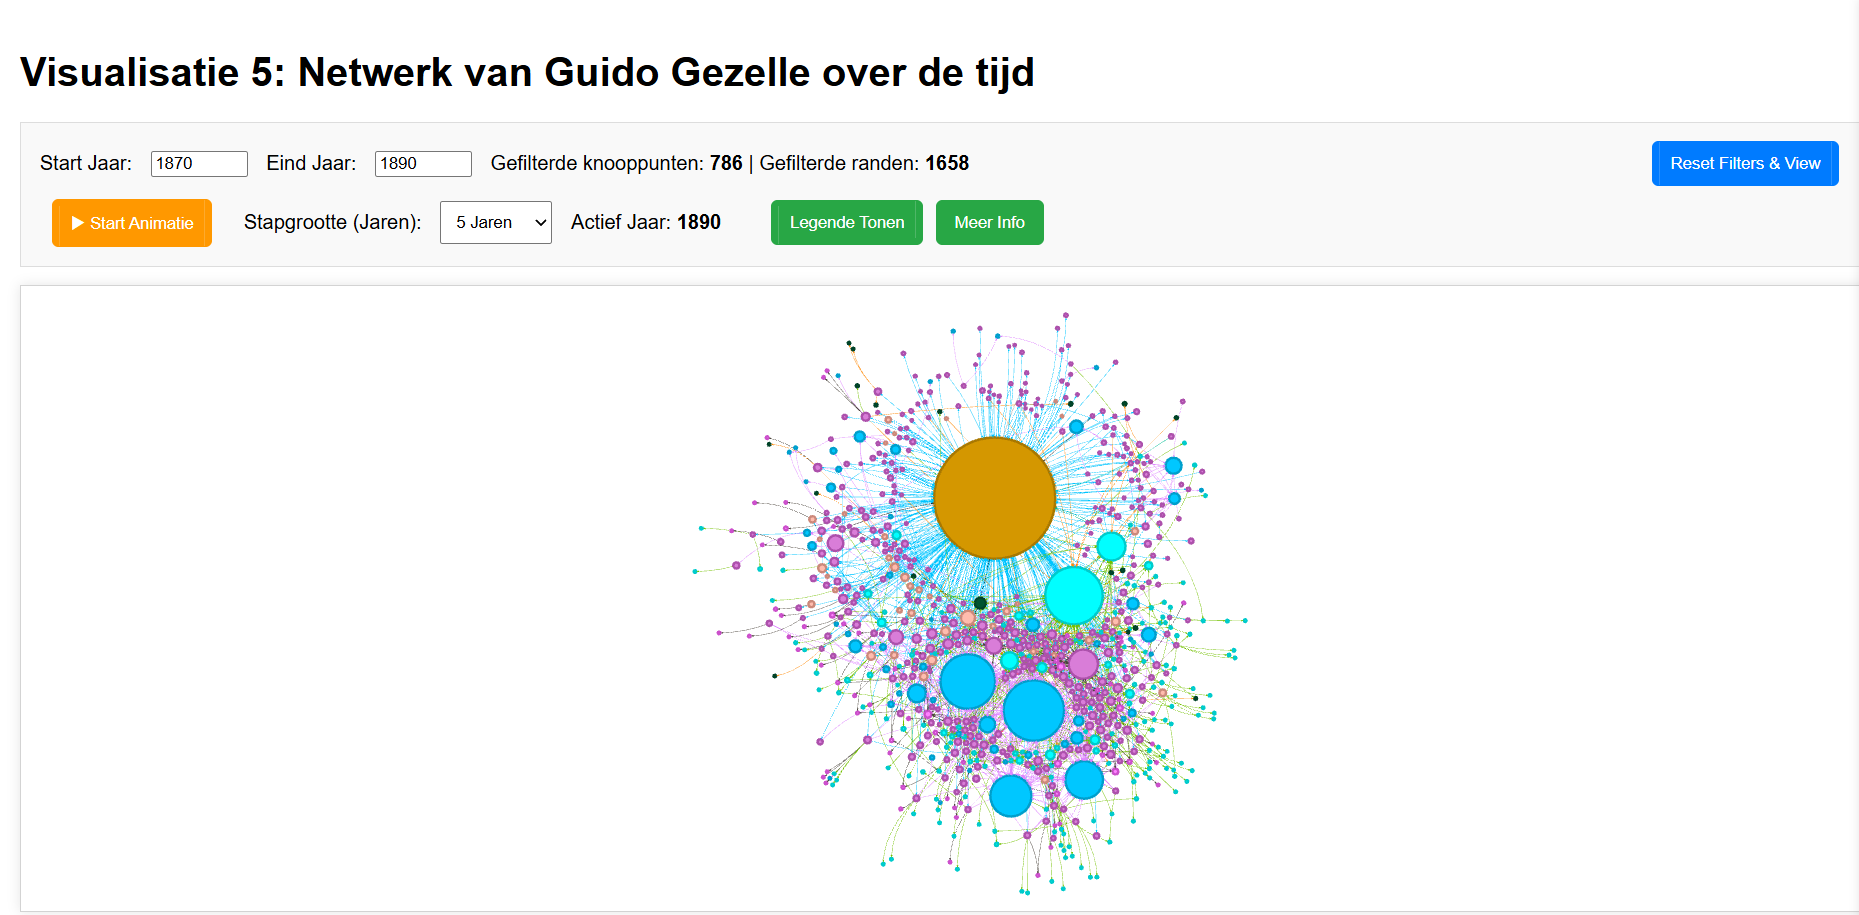

Tip: als je periode met startjaar 1831 en eindjaar 1831 neemt, en aantal jaren per 1, en vervolgens op 'speel animatie' klikt, krijg je de contacten over de tijd te zien, behalve de null-waarden waarvoor we 1830-1899 hebben ingesteld. Zo krijg je een globaal beeld van het ontwikkelend netwerk doorheen de tijd.


In deze handleiding werd een visualisatie gemaakt op basis van beschikbare data omtrent Guido Gezelle.
Eerst werden enkele queries ontworpen. Daarna werden deze via Spreadsheets omgezet naar een knopenbestand en een verbindingenbestand. Daarna werd getoond hoe deze bestanden opgeladen worden in Gephi en er een visualisatie van gemaakt wordt. Er werd stilgestaa6n bij de layout, alsook bij de export en creatie van een unieke interface. In een laatste fase werd de interactieve visualisatie online beschikbaar gemaakt als Github-webpagina. Met behulp van generatieve AI, in dit geval Gemini, werd de code aangepast om wat meer functionaliteit toe te voegen.